# Apply AI Superresolution to video - Train VDSR from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places
- different blur levels- complete
- different blur levels in the same image
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop
- crop to the super8 resolution 720x480 or video 320x240
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution

## losses
- try l1 loss
- try perceptive loss vgg18

## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation



# Project Documentation

In [1]:

project_base = "/media/SSD/superres/"
results_folder = "Results"
training_folder = "video_data"
model_folder = "checkpoint"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train vdsr with perception loss multifuz.ipynb


In [4]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [5]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import os
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
from pathlib import Path
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale

import random
from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel


import sys
sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [6]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers


torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [7]:



toPIL = vision.transforms.ToPILImage()


def noisy(img, std=3.0):
    mean = 0.0
    gauss = np.random.normal(mean, std, (img.height, img.width, 3))
    # noisy = np.clip(np.uint8(img + gauss), 0, 255)
    noisy = np.uint8(img + gauss)
    return noisy


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])



In [8]:
def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10):
    instances = []
    for filename in listdir(video_dir):
        filepath = os.path.join(video_dir,filename)
        #print(filename)
        
        if is_video_file(filepath):
            # open video file
            cap = cv2.VideoCapture(str(filepath))

            # get frame count
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            cap.release()
            
            if frame_sample_size is not None:
                samples = frame_sampler2(length, frame_sample_size)
                # append fn and frame num to instances
            else:
                samples = range(0,length)
                
            for frame in samples:
                item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                instances.append(item)
                
        elif is_image_file(filepath):
            # open image file
            img = cv2.imread(filepath)
            item = {"Filepath":filepath, "Type":"image"}
            instances.append(item)
            
    return instances
        

In [9]:
# get a list of all the data
instances = make_framelist("/media/SSD/superres/video_data",1)

In [10]:
instances

[{'Filepath': '/media/SSD/superres/video_data/101890319.mp4',
  'Type': 'frame',
  'Framenum': 3431},
 {'Filepath': '/media/SSD/superres/video_data/107132164.mp4',
  'Type': 'frame',
  'Framenum': 1634},
 {'Filepath': '/media/SSD/superres/video_data/104453980.mp4',
  'Type': 'frame',
  'Framenum': 15060},
 {'Filepath': '/media/SSD/superres/video_data/103604430.mp4',
  'Type': 'frame',
  'Framenum': 5538},
 {'Filepath': '/media/SSD/superres/video_data/110371795.mp4',
  'Type': 'frame',
  'Framenum': 744},
 {'Filepath': '/media/SSD/superres/video_data/101224055.mp4',
  'Type': 'frame',
  'Framenum': 3954},
 {'Filepath': '/media/SSD/superres/video_data/101094248.mp4',
  'Type': 'frame',
  'Framenum': 3290},
 {'Filepath': '/media/SSD/superres/video_data/106501635.mp4',
  'Type': 'frame',
  'Framenum': 1580},
 {'Filepath': '/media/SSD/superres/video_data/102797996.mp4',
  'Type': 'frame',
  'Framenum': 542},
 {'Filepath': '/media/SSD/superres/video_data/114651311.mp4',
  'Type': 'frame',
  

In [11]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [12]:


class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+self.kernel_width+1)
        h_wanted = int(self.crop_size[1]+self.kernel_width+1)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [13]:


class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,size,frame_sample_size=None, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10):
        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size)

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.size = size
        self.kernel_width = kernel_width

    def __getitem__(self, index):
        input = load_frame(self.video_frames[index])
        
        input = RescaleCrop(self.size,self.kernel_width )(input)
        
        if self.Flip_hor:
            input = RandomHorizontalFlip()(input)
        
        if self.Rand_bright_contrast:
            input = ColorJitter(brightness=.2, contrast=.2)(input)
        
        
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.video_frames)

In [14]:

def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [15]:


class CropRescale(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        #print("size of image",img.size)
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*rand_scale_factor+2)
        h_wanted = int(self.crop_size[1]+2*rand_scale_factor+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img_cv = cv_center_crop(np.array(img),(v_wanted,h_wanted))  

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, Tophat2DKernel(rand_scale_factor).array)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        #rand_quality_factor = random.uniform(30,90)
        #is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        #img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [16]:
class Crappify(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        
        img_cv = np.array(img)

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        k = Tophat2DKernel(int(rand_scale_factor)/2.0).array
        k = k/k.sum()
        
        
        img_cv = cv2.filter2D(img_cv, -1, k)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [17]:
def create_circular_mask(h, w, slope=0.01, center=None, radius=None, scale=1.0):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((scale*(X - center[0]))**2 + ((Y-center[1])/scale)**2)

    mask = np.minimum((np.maximum(dist_from_center-radius,0)*slope)**(0.5),1.0)
    return mask

In [18]:
class Multifuz(object):


    def __init__(self, crop_size ,kernel_range, quality_range, slope_range, radius_range, scale_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_range = kernel_range
        self.quality_range = quality_range
        self.slope_range = slope_range
        self.radius_range = radius_range
        self.scale_range = scale_range
        

    
        

    def __call__(self, img):
        
        img_cv = np.array(img)
        d = img_cv .shape
        dim = (d[1], d[0])
        height = d[0]
        width = d[1]
        color = len(d)-2
        
        rand_kernel = random.uniform(*self.kernel_range)
        rand_quality = random.uniform(*self.quality_range)
        rand_slope = random.uniform(*self.slope_range)
        rand_radius = random.uniform(*self.radius_range)*max(height,width)
        

        rand_center = (random.uniform(0,width),random.uniform(0,height))
        
        rand_scale = random.uniform(0.5,2)
        #technically should adjust the scale to the crop size scale of the final image
        
        #blur kernel A
        
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurA = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        #blur kernel B
        rand_kernel = random.uniform(*self.kernel_range)
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurB = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        
        #add them with a mask
        # Normalize the alpha mask to keep intensity between 0 and 1
        
        alpha = create_circular_mask(h=height, w=width, center=rand_center, radius=rand_radius, scale = rand_scale)*1.0
        
        if color ==1:
            alpha=np.reshape(alpha, (height,width,-1))
            alpha=np.broadcast_to(alpha,[height,width,3])
        
        #alpha = alpha.astype(float)/255
        
        # Multiply the foreground with the alpha matte
        
        img_cv_blurA = cv2.multiply(img_cv_blurA, alpha, dtype=cv2.CV_32F )
        # Multiply the background with ( 1 - alpha )

        
        img_cv_blurB = cv2.multiply(img_cv_blurB, 1.0 - alpha, dtype=cv2.CV_32F)
        # Add the masked foreground and background.

        
        img_cv = cv2.add(img_cv_blurA, img_cv_blurB, dtype=cv2.CV_32F)
        
        img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        
        
        
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

(1280, 720) (1280, 720)


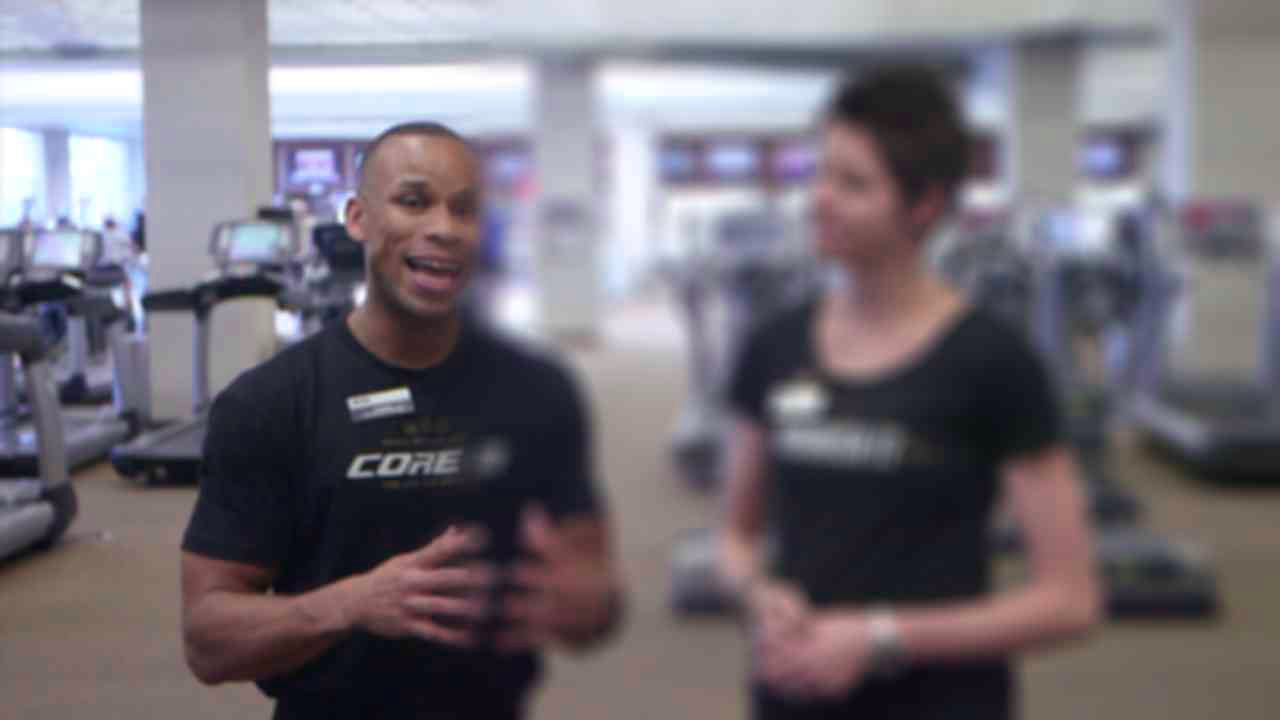

In [25]:
#test the CropRescale transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
#im_res = RescaleCrop(crop_size = (480,720), kernel_width=1)(im)
im_res = Multifuz(crop_size = (720,1280),
                  kernel_range=(4,32), 
                  quality_range=(2,2), 
                  slope_range=(0.00001, 0.001),
                 radius_range=(.05,.75),
                 scale_range=(1/2,2))(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [26]:


def input_transform(crop_size, kernel_range):
    
    
    return Compose([
        
        Multifuz(crop_size = crop_size,
                  kernel_range=kernel_range, 
                  quality_range=(30,90), 
                  slope_range=(0.00001, 0.001),
                 radius_range=(.05,.75),
                 scale_range=(1/2,2)), 
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    print(crop_size)
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])


def get_training_set(data_dir, crop_size, kernel_range, frame_sample_size=10, add_noise=None, 
                     noise_std=3.0,Flip_hor=True,Rand_bright_contrast=True):
    

    cropsize = crop_size
    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=input_transform(
                                 crop_size, kernel_range),
                             target_transform=target_transform(crop_size),
                             add_noise=add_noise,
                             noise_std=noise_std,Flip_hor=Flip_hor,
                             Rand_bright_contrast=Rand_bright_contrast)


## Below functions need work

def get_validation_set(data_dir, crop_size, kernel_range):
    
    
    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, kernel_range,frame_sample_size=10),
                             target_transform=target_transform(cropsize))


def get_test_set(data_dir, crop_size, upscale_factor):


    return DatasetFromVideoFolder(data_dir,frame_sample_size=None,
                             input_transform=input_transform(
                                 cropsize, upscale_factor),
                             target_transform=target_transform(cropsize))

In [27]:
train_dir = "/media/SSD/superres/video_data"
frame_sample_size =10
batch_size = 4 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
kernel_range=(4,20)
add_noise=False
noise_std=3.0
Flip_hor=True
Rand_bright_contrast=True

In [28]:
# create a data set
# split it using random split
# random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))


In [29]:
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

(480, 720)


In [30]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [31]:

def show_batch(dataloader,size = 8):

    inputs, outputs = next(iter(dataloader))
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

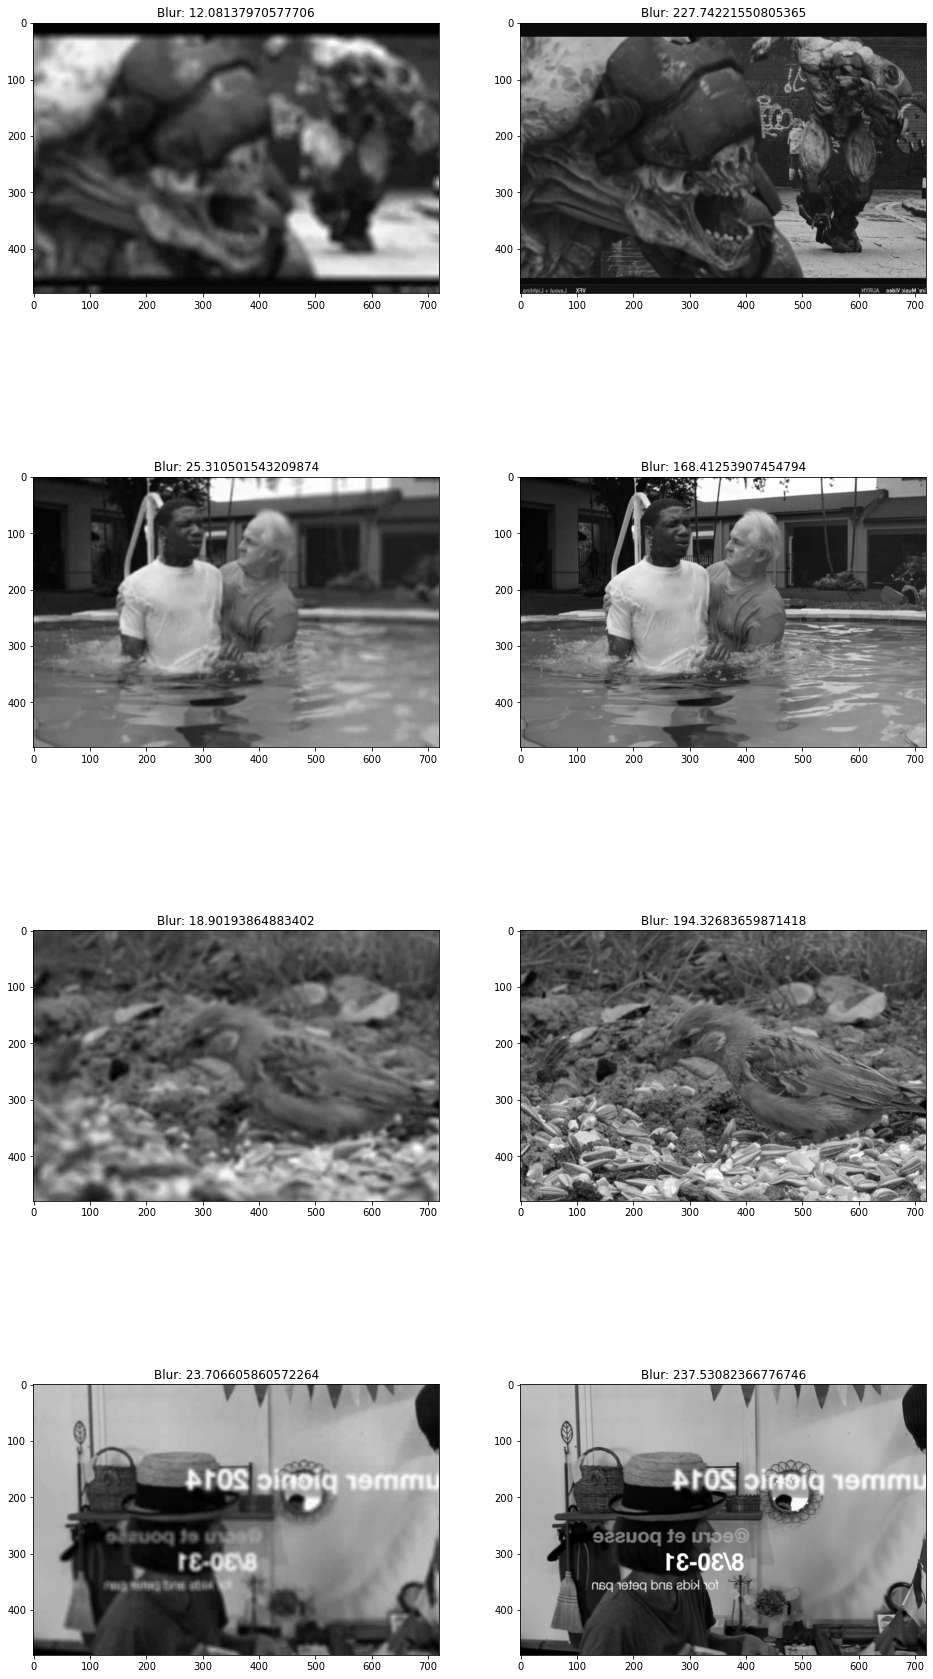

In [32]:
show_batch(training_data_loader,size =8)

# VDSR with dropout

In [ ]:
import torch.nn as nn
from math import sqrt

class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.do = nn.Dropout2d(p=0.5, inplace=True)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, 18)
        self.input = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out

# Build the model

In [ ]:
model = Net()
model.cuda()


In [33]:
model = torch.load("/media/SSD/superres/pytorch-vdsr/model/model_epoch_50.pth")["model"]



/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original sourc

In [ ]:
model

In [34]:
#criterion = nn.MSELoss(reduction = 'sum')
#criterion = nn.L1Loss(reduction = 'sum')

#loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
#loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

loss_fn = lpips.LPIPS(net='alex')
loss_fn.cuda()

def loss_scaler(im):
    # scale to -1,1 and convert to 3 channel (greyscale to RBG)
    return (im * 2 - 1).expand(-1, 3, -1, -1)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /media/SSD/conda_env/superres/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [35]:
class P_Loss(torch.nn.Module):
    
    def __init__(self):
        super(P_Loss,self).__init__()
        
    def forward(self,x,y):
        
        totloss = torch.mean(loss_fn.forward(loss_scaler(x),loss_scaler(y)))
        return totloss

In [36]:
criterion = P_Loss()

#criterion.cuda()

In [37]:
init_lr = 0.1/100
lr_step = 3
gradient_clip = 0.4
epochs = 27

In [38]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)

In [39]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [40]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [41]:
def save_checkpoint(model, epoch):
    model_out_path = "checkpoint/" + "perfuzmodel1_epoch_{}.pth".format(epoch)
    state = {"epoch": epoch ,"model": model}
    if not os.path.exists("checkpoint/"):
        os.makedirs("checkpoint/")

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))

In [42]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [43]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        target = target.cuda()
        
        # Runs the forward pass with autocasting.
        with autocast():
            loss = criterion(model(input), target)
            
        
        optimizer.zero_grad()
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        cum_loss2 = cum_loss2 + loss.data
        ct2=ct2+batch_size
        ct = ct +batch_size
        

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): LR: {} : Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), optimizer.param_groups[0]["lr"], cum_loss/ct))
            ct=0
            cum_loss =0
    print("Epoch Loss:", cum_loss2/ct2)        

In [44]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(model, epoch)

Start Time: 2020-09-23 21:36:18.581750
Epoch = 1, lr = 0.001
===> Time: 2020-09-23 21:36:31.030272 Epoch[1](10/1586): LR: 0.001 : Loss: 0.0752563477
===> Time: 2020-09-23 21:36:42.834127 Epoch[1](20/1586): LR: 0.001 : Loss: 0.0708007812
===> Time: 2020-09-23 21:36:54.623568 Epoch[1](30/1586): LR: 0.001 : Loss: 0.0671997070
===> Time: 2020-09-23 21:37:06.360736 Epoch[1](40/1586): LR: 0.001 : Loss: 0.0574951172
===> Time: 2020-09-23 21:37:18.565690 Epoch[1](50/1586): LR: 0.001 : Loss: 0.0634765625
===> Time: 2020-09-23 21:37:30.773127 Epoch[1](60/1586): LR: 0.001 : Loss: 0.0717163086
===> Time: 2020-09-23 21:37:42.592183 Epoch[1](70/1586): LR: 0.001 : Loss: 0.0592041016
===> Time: 2020-09-23 21:37:54.895052 Epoch[1](80/1586): LR: 0.001 : Loss: 0.0712280273
===> Time: 2020-09-23 21:38:07.107191 Epoch[1](90/1586): LR: 0.001 : Loss: 0.0715942383
===> Time: 2020-09-23 21:38:18.954600 Epoch[1](100/1586): LR: 0.001 : Loss: 0.0642700195
===> Time: 2020-09-23 21:38:30.856624 Epoch[1](110/1586): 

===> Time: 2020-09-23 21:54:51.722440 Epoch[1](930/1586): LR: 0.001 : Loss: 0.0640869141
===> Time: 2020-09-23 21:55:03.403982 Epoch[1](940/1586): LR: 0.001 : Loss: 0.0589294434
===> Time: 2020-09-23 21:55:15.019767 Epoch[1](950/1586): LR: 0.001 : Loss: 0.0572204590
===> Time: 2020-09-23 21:55:26.525685 Epoch[1](960/1586): LR: 0.001 : Loss: 0.0571594238
===> Time: 2020-09-23 21:55:38.402411 Epoch[1](970/1586): LR: 0.001 : Loss: 0.0574035645
===> Time: 2020-09-23 21:55:50.177460 Epoch[1](980/1586): LR: 0.001 : Loss: 0.0560913086
===> Time: 2020-09-23 21:56:01.784819 Epoch[1](990/1586): LR: 0.001 : Loss: 0.0561523438
===> Time: 2020-09-23 21:56:13.516882 Epoch[1](1000/1586): LR: 0.001 : Loss: 0.0588378906
===> Time: 2020-09-23 21:56:25.155981 Epoch[1](1010/1586): LR: 0.001 : Loss: 0.0578002930
===> Time: 2020-09-23 21:56:37.106526 Epoch[1](1020/1586): LR: 0.001 : Loss: 0.0656738281
===> Time: 2020-09-23 21:56:48.957462 Epoch[1](1030/1586): LR: 0.001 : Loss: 0.0569763184
===> Time: 2020-0

===> Time: 2020-09-23 22:12:33.240096 Epoch[2](250/1586): LR: 0.001 : Loss: 0.0463867188
===> Time: 2020-09-23 22:12:45.057541 Epoch[2](260/1586): LR: 0.001 : Loss: 0.0596923828
===> Time: 2020-09-23 22:12:56.891893 Epoch[2](270/1586): LR: 0.001 : Loss: 0.0512695312
===> Time: 2020-09-23 22:13:08.566352 Epoch[2](280/1586): LR: 0.001 : Loss: 0.0587768555
===> Time: 2020-09-23 22:13:20.303702 Epoch[2](290/1586): LR: 0.001 : Loss: 0.0596008301
===> Time: 2020-09-23 22:13:31.935517 Epoch[2](300/1586): LR: 0.001 : Loss: 0.0625610352
===> Time: 2020-09-23 22:13:43.558896 Epoch[2](310/1586): LR: 0.001 : Loss: 0.0567626953
===> Time: 2020-09-23 22:13:55.126822 Epoch[2](320/1586): LR: 0.001 : Loss: 0.0517883301
===> Time: 2020-09-23 22:14:06.898202 Epoch[2](330/1586): LR: 0.001 : Loss: 0.0580444336
===> Time: 2020-09-23 22:14:18.669816 Epoch[2](340/1586): LR: 0.001 : Loss: 0.0542297363
===> Time: 2020-09-23 22:14:30.123112 Epoch[2](350/1586): LR: 0.001 : Loss: 0.0511169434
===> Time: 2020-09-23

===> Time: 2020-09-23 22:30:26.991084 Epoch[2](1170/1586): LR: 0.001 : Loss: 0.0531005859
===> Time: 2020-09-23 22:30:38.686192 Epoch[2](1180/1586): LR: 0.001 : Loss: 0.0578002930
===> Time: 2020-09-23 22:30:50.301478 Epoch[2](1190/1586): LR: 0.001 : Loss: 0.0568237305
===> Time: 2020-09-23 22:31:02.045287 Epoch[2](1200/1586): LR: 0.001 : Loss: 0.0547790527
===> Time: 2020-09-23 22:31:13.615545 Epoch[2](1210/1586): LR: 0.001 : Loss: 0.0498657227
===> Time: 2020-09-23 22:31:25.245638 Epoch[2](1220/1586): LR: 0.001 : Loss: 0.0564270020
===> Time: 2020-09-23 22:31:36.820900 Epoch[2](1230/1586): LR: 0.001 : Loss: 0.0540771484
===> Time: 2020-09-23 22:31:48.403563 Epoch[2](1240/1586): LR: 0.001 : Loss: 0.0595092773
===> Time: 2020-09-23 22:32:00.040051 Epoch[2](1250/1586): LR: 0.001 : Loss: 0.0533447266
===> Time: 2020-09-23 22:32:11.451818 Epoch[2](1260/1586): LR: 0.001 : Loss: 0.0501403809
===> Time: 2020-09-23 22:32:23.082876 Epoch[2](1270/1586): LR: 0.001 : Loss: 0.0522460938
===> Time:

===> Time: 2020-09-23 22:48:04.108922 Epoch[3](490/1586): LR: 0.001 : Loss: 0.0574951172
===> Time: 2020-09-23 22:48:15.677597 Epoch[3](500/1586): LR: 0.001 : Loss: 0.0584716797
===> Time: 2020-09-23 22:48:27.145428 Epoch[3](510/1586): LR: 0.001 : Loss: 0.0581970215
===> Time: 2020-09-23 22:48:38.739331 Epoch[3](520/1586): LR: 0.001 : Loss: 0.0596923828
===> Time: 2020-09-23 22:48:50.462999 Epoch[3](530/1586): LR: 0.001 : Loss: 0.0525817871
===> Time: 2020-09-23 22:49:02.064860 Epoch[3](540/1586): LR: 0.001 : Loss: 0.0533142090
===> Time: 2020-09-23 22:49:13.699836 Epoch[3](550/1586): LR: 0.001 : Loss: 0.0611572266
===> Time: 2020-09-23 22:49:25.397930 Epoch[3](560/1586): LR: 0.001 : Loss: 0.0534667969
===> Time: 2020-09-23 22:49:37.365461 Epoch[3](570/1586): LR: 0.001 : Loss: 0.0610351562
===> Time: 2020-09-23 22:49:49.076455 Epoch[3](580/1586): LR: 0.001 : Loss: 0.0630493164
===> Time: 2020-09-23 22:50:00.805171 Epoch[3](590/1586): LR: 0.001 : Loss: 0.0640258789
===> Time: 2020-09-23

===> Time: 2020-09-23 23:05:56.817012 Epoch[3](1410/1586): LR: 0.001 : Loss: 0.0518798828
===> Time: 2020-09-23 23:06:08.699882 Epoch[3](1420/1586): LR: 0.001 : Loss: 0.0590209961
===> Time: 2020-09-23 23:06:20.450458 Epoch[3](1430/1586): LR: 0.001 : Loss: 0.0528564453
===> Time: 2020-09-23 23:06:32.149902 Epoch[3](1440/1586): LR: 0.001 : Loss: 0.0546264648
===> Time: 2020-09-23 23:06:43.825479 Epoch[3](1450/1586): LR: 0.001 : Loss: 0.0550537109
===> Time: 2020-09-23 23:06:55.290615 Epoch[3](1460/1586): LR: 0.001 : Loss: 0.0467529297
===> Time: 2020-09-23 23:07:07.097228 Epoch[3](1470/1586): LR: 0.001 : Loss: 0.0546264648
===> Time: 2020-09-23 23:07:18.917062 Epoch[3](1480/1586): LR: 0.001 : Loss: 0.0559082031
===> Time: 2020-09-23 23:07:30.506497 Epoch[3](1490/1586): LR: 0.001 : Loss: 0.0531005859
===> Time: 2020-09-23 23:07:42.221246 Epoch[3](1500/1586): LR: 0.001 : Loss: 0.0573730469
===> Time: 2020-09-23 23:07:53.864538 Epoch[3](1510/1586): LR: 0.001 : Loss: 0.0471191406
===> Time:

===> Time: 2020-09-23 23:21:26.283684 Epoch[4](620/1586): LR: 0.00031622776601683794 : Loss: 0.0504760742
===> Time: 2020-09-23 23:21:37.960691 Epoch[4](630/1586): LR: 0.00031622776601683794 : Loss: 0.0536499023
===> Time: 2020-09-23 23:21:49.582590 Epoch[4](640/1586): LR: 0.00031622776601683794 : Loss: 0.0564270020
===> Time: 2020-09-23 23:22:01.207974 Epoch[4](650/1586): LR: 0.00031622776601683794 : Loss: 0.0513610840
===> Time: 2020-09-23 23:22:12.978551 Epoch[4](660/1586): LR: 0.00031622776601683794 : Loss: 0.0519409180
===> Time: 2020-09-23 23:22:24.326412 Epoch[4](670/1586): LR: 0.00031622776601683794 : Loss: 0.0457153320
===> Time: 2020-09-23 23:22:35.983465 Epoch[4](680/1586): LR: 0.00031622776601683794 : Loss: 0.0565795898
===> Time: 2020-09-23 23:22:47.570532 Epoch[4](690/1586): LR: 0.00031622776601683794 : Loss: 0.0511474609
===> Time: 2020-09-23 23:22:58.944422 Epoch[4](700/1586): LR: 0.00031622776601683794 : Loss: 0.0537109375
===> Time: 2020-09-23 23:23:10.697575 Epoch[4]

===> Time: 2020-09-23 23:36:18.972259 Epoch[4](1390/1586): LR: 0.00031622776601683794 : Loss: 0.0564880371
===> Time: 2020-09-23 23:36:30.548638 Epoch[4](1400/1586): LR: 0.00031622776601683794 : Loss: 0.0573730469
===> Time: 2020-09-23 23:36:42.205294 Epoch[4](1410/1586): LR: 0.00031622776601683794 : Loss: 0.0489501953
===> Time: 2020-09-23 23:36:53.864383 Epoch[4](1420/1586): LR: 0.00031622776601683794 : Loss: 0.0479736328
===> Time: 2020-09-23 23:37:05.286251 Epoch[4](1430/1586): LR: 0.00031622776601683794 : Loss: 0.0473022461
===> Time: 2020-09-23 23:37:16.731129 Epoch[4](1440/1586): LR: 0.00031622776601683794 : Loss: 0.0472717285
===> Time: 2020-09-23 23:37:28.129691 Epoch[4](1450/1586): LR: 0.00031622776601683794 : Loss: 0.0461425781
===> Time: 2020-09-23 23:37:39.642896 Epoch[4](1460/1586): LR: 0.00031622776601683794 : Loss: 0.0513000488
===> Time: 2020-09-23 23:37:51.355275 Epoch[4](1470/1586): LR: 0.00031622776601683794 : Loss: 0.0501403809
===> Time: 2020-09-23 23:38:03.047453

===> Time: 2020-09-23 23:51:09.297243 Epoch[5](570/1586): LR: 0.00031622776601683794 : Loss: 0.0515441895
===> Time: 2020-09-23 23:51:20.957051 Epoch[5](580/1586): LR: 0.00031622776601683794 : Loss: 0.0491943359
===> Time: 2020-09-23 23:51:32.613762 Epoch[5](590/1586): LR: 0.00031622776601683794 : Loss: 0.0469970703
===> Time: 2020-09-23 23:51:44.300873 Epoch[5](600/1586): LR: 0.00031622776601683794 : Loss: 0.0542907715
===> Time: 2020-09-23 23:51:56.113073 Epoch[5](610/1586): LR: 0.00031622776601683794 : Loss: 0.0517883301
===> Time: 2020-09-23 23:52:07.532231 Epoch[5](620/1586): LR: 0.00031622776601683794 : Loss: 0.0449218750
===> Time: 2020-09-23 23:52:18.929152 Epoch[5](630/1586): LR: 0.00031622776601683794 : Loss: 0.0474853516
===> Time: 2020-09-23 23:52:30.547304 Epoch[5](640/1586): LR: 0.00031622776601683794 : Loss: 0.0562744141
===> Time: 2020-09-23 23:52:42.173091 Epoch[5](650/1586): LR: 0.00031622776601683794 : Loss: 0.0570678711
===> Time: 2020-09-23 23:52:53.821723 Epoch[5]

===> Time: 2020-09-24 00:06:03.500877 Epoch[5](1340/1586): LR: 0.00031622776601683794 : Loss: 0.0467529297
===> Time: 2020-09-24 00:06:15.161442 Epoch[5](1350/1586): LR: 0.00031622776601683794 : Loss: 0.0473632812
===> Time: 2020-09-24 00:06:26.687705 Epoch[5](1360/1586): LR: 0.00031622776601683794 : Loss: 0.0505371094
===> Time: 2020-09-24 00:06:38.321474 Epoch[5](1370/1586): LR: 0.00031622776601683794 : Loss: 0.0485229492
===> Time: 2020-09-24 00:06:49.724662 Epoch[5](1380/1586): LR: 0.00031622776601683794 : Loss: 0.0514526367
===> Time: 2020-09-24 00:07:01.282329 Epoch[5](1390/1586): LR: 0.00031622776601683794 : Loss: 0.0516967773
===> Time: 2020-09-24 00:07:12.997225 Epoch[5](1400/1586): LR: 0.00031622776601683794 : Loss: 0.0523681641
===> Time: 2020-09-24 00:07:24.584470 Epoch[5](1410/1586): LR: 0.00031622776601683794 : Loss: 0.0490417480
===> Time: 2020-09-24 00:07:36.290654 Epoch[5](1420/1586): LR: 0.00031622776601683794 : Loss: 0.0513610840
===> Time: 2020-09-24 00:07:47.887055

===> Time: 2020-09-24 00:20:52.048489 Epoch[6](520/1586): LR: 0.00031622776601683794 : Loss: 0.0545349121
===> Time: 2020-09-24 00:21:03.507615 Epoch[6](530/1586): LR: 0.00031622776601683794 : Loss: 0.0486145020
===> Time: 2020-09-24 00:21:15.132568 Epoch[6](540/1586): LR: 0.00031622776601683794 : Loss: 0.0567626953
===> Time: 2020-09-24 00:21:26.547892 Epoch[6](550/1586): LR: 0.00031622776601683794 : Loss: 0.0471191406
===> Time: 2020-09-24 00:21:37.994692 Epoch[6](560/1586): LR: 0.00031622776601683794 : Loss: 0.0567626953
===> Time: 2020-09-24 00:21:49.848127 Epoch[6](570/1586): LR: 0.00031622776601683794 : Loss: 0.0564270020
===> Time: 2020-09-24 00:22:01.788775 Epoch[6](580/1586): LR: 0.00031622776601683794 : Loss: 0.0564880371
===> Time: 2020-09-24 00:22:13.448409 Epoch[6](590/1586): LR: 0.00031622776601683794 : Loss: 0.0530700684
===> Time: 2020-09-24 00:22:25.169482 Epoch[6](600/1586): LR: 0.00031622776601683794 : Loss: 0.0538940430
===> Time: 2020-09-24 00:22:36.761003 Epoch[6]

===> Time: 2020-09-24 00:35:58.147076 Epoch[6](1300/1586): LR: 0.00031622776601683794 : Loss: 0.0523681641
===> Time: 2020-09-24 00:36:09.926829 Epoch[6](1310/1586): LR: 0.00031622776601683794 : Loss: 0.0508728027
===> Time: 2020-09-24 00:36:21.322158 Epoch[6](1320/1586): LR: 0.00031622776601683794 : Loss: 0.0545654297
===> Time: 2020-09-24 00:36:32.807769 Epoch[6](1330/1586): LR: 0.00031622776601683794 : Loss: 0.0496826172
===> Time: 2020-09-24 00:36:44.603689 Epoch[6](1340/1586): LR: 0.00031622776601683794 : Loss: 0.0525207520
===> Time: 2020-09-24 00:36:56.116942 Epoch[6](1350/1586): LR: 0.00031622776601683794 : Loss: 0.0476074219
===> Time: 2020-09-24 00:37:07.907252 Epoch[6](1360/1586): LR: 0.00031622776601683794 : Loss: 0.0522460938
===> Time: 2020-09-24 00:37:19.636423 Epoch[6](1370/1586): LR: 0.00031622776601683794 : Loss: 0.0551147461
===> Time: 2020-09-24 00:37:31.152651 Epoch[6](1380/1586): LR: 0.00031622776601683794 : Loss: 0.0537414551
===> Time: 2020-09-24 00:37:42.593733

===> Time: 2020-09-24 00:52:20.439627 Epoch[7](560/1586): LR: 0.0001 : Loss: 0.0552062988
===> Time: 2020-09-24 00:52:31.862334 Epoch[7](570/1586): LR: 0.0001 : Loss: 0.0500793457
===> Time: 2020-09-24 00:52:43.476308 Epoch[7](580/1586): LR: 0.0001 : Loss: 0.0520324707
===> Time: 2020-09-24 00:52:55.107066 Epoch[7](590/1586): LR: 0.0001 : Loss: 0.0533142090
===> Time: 2020-09-24 00:53:06.972363 Epoch[7](600/1586): LR: 0.0001 : Loss: 0.0525817871
===> Time: 2020-09-24 00:53:18.273178 Epoch[7](610/1586): LR: 0.0001 : Loss: 0.0520935059
===> Time: 2020-09-24 00:53:30.051551 Epoch[7](620/1586): LR: 0.0001 : Loss: 0.0532531738
===> Time: 2020-09-24 00:53:41.650194 Epoch[7](630/1586): LR: 0.0001 : Loss: 0.0486145020
===> Time: 2020-09-24 00:53:53.198557 Epoch[7](640/1586): LR: 0.0001 : Loss: 0.0556030273
===> Time: 2020-09-24 00:54:04.600043 Epoch[7](650/1586): LR: 0.0001 : Loss: 0.0485839844
===> Time: 2020-09-24 00:54:16.110516 Epoch[7](660/1586): LR: 0.0001 : Loss: 0.0498046875
===> Time:

===> Time: 2020-09-24 01:09:54.707512 Epoch[7](1470/1586): LR: 0.0001 : Loss: 0.0479736328
===> Time: 2020-09-24 01:10:06.223763 Epoch[7](1480/1586): LR: 0.0001 : Loss: 0.0498962402
===> Time: 2020-09-24 01:10:17.944360 Epoch[7](1490/1586): LR: 0.0001 : Loss: 0.0517883301
===> Time: 2020-09-24 01:10:29.648060 Epoch[7](1500/1586): LR: 0.0001 : Loss: 0.0534057617
===> Time: 2020-09-24 01:10:41.382992 Epoch[7](1510/1586): LR: 0.0001 : Loss: 0.0496520996
===> Time: 2020-09-24 01:10:53.105308 Epoch[7](1520/1586): LR: 0.0001 : Loss: 0.0547180176
===> Time: 2020-09-24 01:11:04.668608 Epoch[7](1530/1586): LR: 0.0001 : Loss: 0.0484313965
===> Time: 2020-09-24 01:11:16.370982 Epoch[7](1540/1586): LR: 0.0001 : Loss: 0.0471191406
===> Time: 2020-09-24 01:11:27.935514 Epoch[7](1550/1586): LR: 0.0001 : Loss: 0.0533447266
===> Time: 2020-09-24 01:11:39.473621 Epoch[7](1560/1586): LR: 0.0001 : Loss: 0.0479736328
===> Time: 2020-09-24 01:11:50.931820 Epoch[7](1570/1586): LR: 0.0001 : Loss: 0.0463256836

===> Time: 2020-09-24 01:27:14.142638 Epoch[8](780/1586): LR: 0.0001 : Loss: 0.0513916016
===> Time: 2020-09-24 01:27:25.840003 Epoch[8](790/1586): LR: 0.0001 : Loss: 0.0551147461
===> Time: 2020-09-24 01:27:37.418965 Epoch[8](800/1586): LR: 0.0001 : Loss: 0.0546264648
===> Time: 2020-09-24 01:27:48.962851 Epoch[8](810/1586): LR: 0.0001 : Loss: 0.0497741699
===> Time: 2020-09-24 01:28:00.421040 Epoch[8](820/1586): LR: 0.0001 : Loss: 0.0479736328
===> Time: 2020-09-24 01:28:11.899881 Epoch[8](830/1586): LR: 0.0001 : Loss: 0.0452880859
===> Time: 2020-09-24 01:28:23.455003 Epoch[8](840/1586): LR: 0.0001 : Loss: 0.0493774414
===> Time: 2020-09-24 01:28:34.873314 Epoch[8](850/1586): LR: 0.0001 : Loss: 0.0498046875
===> Time: 2020-09-24 01:28:46.536598 Epoch[8](860/1586): LR: 0.0001 : Loss: 0.0480346680
===> Time: 2020-09-24 01:28:58.102564 Epoch[8](870/1586): LR: 0.0001 : Loss: 0.0515136719
===> Time: 2020-09-24 01:29:09.683488 Epoch[8](880/1586): LR: 0.0001 : Loss: 0.0480346680
===> Time:

===> Time: 2020-09-24 01:44:32.654477 Epoch[9](90/1586): LR: 0.0001 : Loss: 0.0469055176
===> Time: 2020-09-24 01:44:44.531451 Epoch[9](100/1586): LR: 0.0001 : Loss: 0.0559082031
===> Time: 2020-09-24 01:44:56.202905 Epoch[9](110/1586): LR: 0.0001 : Loss: 0.0498657227
===> Time: 2020-09-24 01:45:07.948557 Epoch[9](120/1586): LR: 0.0001 : Loss: 0.0510559082
===> Time: 2020-09-24 01:45:19.655315 Epoch[9](130/1586): LR: 0.0001 : Loss: 0.0501403809
===> Time: 2020-09-24 01:45:31.289747 Epoch[9](140/1586): LR: 0.0001 : Loss: 0.0563354492
===> Time: 2020-09-24 01:45:43.129927 Epoch[9](150/1586): LR: 0.0001 : Loss: 0.0488891602
===> Time: 2020-09-24 01:45:54.829745 Epoch[9](160/1586): LR: 0.0001 : Loss: 0.0564270020
===> Time: 2020-09-24 01:46:06.437919 Epoch[9](170/1586): LR: 0.0001 : Loss: 0.0480957031
===> Time: 2020-09-24 01:46:18.024258 Epoch[9](180/1586): LR: 0.0001 : Loss: 0.0501708984
===> Time: 2020-09-24 01:46:29.555397 Epoch[9](190/1586): LR: 0.0001 : Loss: 0.0453491211
===> Time: 

===> Time: 2020-09-24 02:02:17.828502 Epoch[9](1010/1586): LR: 0.0001 : Loss: 0.0510253906
===> Time: 2020-09-24 02:02:29.266549 Epoch[9](1020/1586): LR: 0.0001 : Loss: 0.0507202148
===> Time: 2020-09-24 02:02:40.856365 Epoch[9](1030/1586): LR: 0.0001 : Loss: 0.0513610840
===> Time: 2020-09-24 02:02:52.672315 Epoch[9](1040/1586): LR: 0.0001 : Loss: 0.0604858398
===> Time: 2020-09-24 02:03:04.142816 Epoch[9](1050/1586): LR: 0.0001 : Loss: 0.0464172363
===> Time: 2020-09-24 02:03:15.911572 Epoch[9](1060/1586): LR: 0.0001 : Loss: 0.0512695312
===> Time: 2020-09-24 02:03:27.432470 Epoch[9](1070/1586): LR: 0.0001 : Loss: 0.0483398438
===> Time: 2020-09-24 02:03:39.145491 Epoch[9](1080/1586): LR: 0.0001 : Loss: 0.0528259277
===> Time: 2020-09-24 02:03:50.449721 Epoch[9](1090/1586): LR: 0.0001 : Loss: 0.0480346680
===> Time: 2020-09-24 02:04:02.131610 Epoch[9](1100/1586): LR: 0.0001 : Loss: 0.0496826172
===> Time: 2020-09-24 02:04:13.695056 Epoch[9](1110/1586): LR: 0.0001 : Loss: 0.0501403809

===> Time: 2020-09-24 02:18:38.422812 Epoch[10](270/1586): LR: 3.16227766016838e-05 : Loss: 0.0454711914
===> Time: 2020-09-24 02:18:49.769604 Epoch[10](280/1586): LR: 3.16227766016838e-05 : Loss: 0.0535888672
===> Time: 2020-09-24 02:19:01.345270 Epoch[10](290/1586): LR: 3.16227766016838e-05 : Loss: 0.0459899902
===> Time: 2020-09-24 02:19:12.771787 Epoch[10](300/1586): LR: 3.16227766016838e-05 : Loss: 0.0437622070
===> Time: 2020-09-24 02:19:24.305412 Epoch[10](310/1586): LR: 3.16227766016838e-05 : Loss: 0.0567626953
===> Time: 2020-09-24 02:19:35.798138 Epoch[10](320/1586): LR: 3.16227766016838e-05 : Loss: 0.0491333008
===> Time: 2020-09-24 02:19:47.436694 Epoch[10](330/1586): LR: 3.16227766016838e-05 : Loss: 0.0463256836
===> Time: 2020-09-24 02:19:58.992693 Epoch[10](340/1586): LR: 3.16227766016838e-05 : Loss: 0.0465087891
===> Time: 2020-09-24 02:20:10.569074 Epoch[10](350/1586): LR: 3.16227766016838e-05 : Loss: 0.0540771484
===> Time: 2020-09-24 02:20:21.997824 Epoch[10](360/158

===> Time: 2020-09-24 02:33:41.181990 Epoch[10](1050/1586): LR: 3.16227766016838e-05 : Loss: 0.0493164062
===> Time: 2020-09-24 02:33:52.942455 Epoch[10](1060/1586): LR: 3.16227766016838e-05 : Loss: 0.0482482910
===> Time: 2020-09-24 02:34:04.605924 Epoch[10](1070/1586): LR: 3.16227766016838e-05 : Loss: 0.0496215820
===> Time: 2020-09-24 02:34:16.203557 Epoch[10](1080/1586): LR: 3.16227766016838e-05 : Loss: 0.0535888672
===> Time: 2020-09-24 02:34:27.996087 Epoch[10](1090/1586): LR: 3.16227766016838e-05 : Loss: 0.0525817871
===> Time: 2020-09-24 02:34:39.632565 Epoch[10](1100/1586): LR: 3.16227766016838e-05 : Loss: 0.0491027832
===> Time: 2020-09-24 02:34:51.187639 Epoch[10](1110/1586): LR: 3.16227766016838e-05 : Loss: 0.0469055176
===> Time: 2020-09-24 02:35:02.717966 Epoch[10](1120/1586): LR: 3.16227766016838e-05 : Loss: 0.0476074219
===> Time: 2020-09-24 02:35:14.405011 Epoch[10](1130/1586): LR: 3.16227766016838e-05 : Loss: 0.0512084961
===> Time: 2020-09-24 02:35:25.899865 Epoch[10

===> Time: 2020-09-24 02:48:31.779463 Epoch[11](230/1586): LR: 3.16227766016838e-05 : Loss: 0.0498657227
===> Time: 2020-09-24 02:48:43.252509 Epoch[11](240/1586): LR: 3.16227766016838e-05 : Loss: 0.0466308594
===> Time: 2020-09-24 02:48:54.624523 Epoch[11](250/1586): LR: 3.16227766016838e-05 : Loss: 0.0476379395
===> Time: 2020-09-24 02:49:06.148950 Epoch[11](260/1586): LR: 3.16227766016838e-05 : Loss: 0.0537414551
===> Time: 2020-09-24 02:49:17.738048 Epoch[11](270/1586): LR: 3.16227766016838e-05 : Loss: 0.0496520996
===> Time: 2020-09-24 02:49:29.483369 Epoch[11](280/1586): LR: 3.16227766016838e-05 : Loss: 0.0504150391
===> Time: 2020-09-24 02:49:41.089802 Epoch[11](290/1586): LR: 3.16227766016838e-05 : Loss: 0.0520019531
===> Time: 2020-09-24 02:49:52.657455 Epoch[11](300/1586): LR: 3.16227766016838e-05 : Loss: 0.0457458496
===> Time: 2020-09-24 02:50:04.115357 Epoch[11](310/1586): LR: 3.16227766016838e-05 : Loss: 0.0456237793
===> Time: 2020-09-24 02:50:15.632314 Epoch[11](320/158

===> Time: 2020-09-24 03:03:47.972774 Epoch[11](1020/1586): LR: 3.16227766016838e-05 : Loss: 0.0549621582
===> Time: 2020-09-24 03:03:59.628899 Epoch[11](1030/1586): LR: 3.16227766016838e-05 : Loss: 0.0501403809
===> Time: 2020-09-24 03:04:11.360534 Epoch[11](1040/1586): LR: 3.16227766016838e-05 : Loss: 0.0482788086
===> Time: 2020-09-24 03:04:23.019084 Epoch[11](1050/1586): LR: 3.16227766016838e-05 : Loss: 0.0530090332
===> Time: 2020-09-24 03:04:34.775743 Epoch[11](1060/1586): LR: 3.16227766016838e-05 : Loss: 0.0474853516
===> Time: 2020-09-24 03:04:46.203512 Epoch[11](1070/1586): LR: 3.16227766016838e-05 : Loss: 0.0506286621
===> Time: 2020-09-24 03:04:57.998134 Epoch[11](1080/1586): LR: 3.16227766016838e-05 : Loss: 0.0599060059
===> Time: 2020-09-24 03:05:09.643402 Epoch[11](1090/1586): LR: 3.16227766016838e-05 : Loss: 0.0500793457
===> Time: 2020-09-24 03:05:21.455868 Epoch[11](1100/1586): LR: 3.16227766016838e-05 : Loss: 0.0537414551
===> Time: 2020-09-24 03:05:32.956056 Epoch[11

===> Time: 2020-09-24 03:19:03.378150 Epoch[12](200/1586): LR: 3.16227766016838e-05 : Loss: 0.0506591797
===> Time: 2020-09-24 03:19:15.949061 Epoch[12](210/1586): LR: 3.16227766016838e-05 : Loss: 0.0443115234
===> Time: 2020-09-24 03:19:28.424101 Epoch[12](220/1586): LR: 3.16227766016838e-05 : Loss: 0.0530090332
===> Time: 2020-09-24 03:19:41.035377 Epoch[12](230/1586): LR: 3.16227766016838e-05 : Loss: 0.0544433594
===> Time: 2020-09-24 03:19:53.466260 Epoch[12](240/1586): LR: 3.16227766016838e-05 : Loss: 0.0516357422
===> Time: 2020-09-24 03:20:05.739795 Epoch[12](250/1586): LR: 3.16227766016838e-05 : Loss: 0.0556945801
===> Time: 2020-09-24 03:20:18.118801 Epoch[12](260/1586): LR: 3.16227766016838e-05 : Loss: 0.0459899902
===> Time: 2020-09-24 03:20:30.919562 Epoch[12](270/1586): LR: 3.16227766016838e-05 : Loss: 0.0567626953
===> Time: 2020-09-24 03:20:43.211095 Epoch[12](280/1586): LR: 3.16227766016838e-05 : Loss: 0.0471191406
===> Time: 2020-09-24 03:20:55.782562 Epoch[12](290/158

===> Time: 2020-09-24 03:35:22.297177 Epoch[12](990/1586): LR: 3.16227766016838e-05 : Loss: 0.0486755371
===> Time: 2020-09-24 03:35:34.585071 Epoch[12](1000/1586): LR: 3.16227766016838e-05 : Loss: 0.0469055176
===> Time: 2020-09-24 03:35:46.798947 Epoch[12](1010/1586): LR: 3.16227766016838e-05 : Loss: 0.0497436523
===> Time: 2020-09-24 03:35:58.949267 Epoch[12](1020/1586): LR: 3.16227766016838e-05 : Loss: 0.0502929688
===> Time: 2020-09-24 03:36:11.243251 Epoch[12](1030/1586): LR: 3.16227766016838e-05 : Loss: 0.0471191406
===> Time: 2020-09-24 03:36:23.547535 Epoch[12](1040/1586): LR: 3.16227766016838e-05 : Loss: 0.0505371094
===> Time: 2020-09-24 03:36:35.718804 Epoch[12](1050/1586): LR: 3.16227766016838e-05 : Loss: 0.0541381836
===> Time: 2020-09-24 03:36:47.854257 Epoch[12](1060/1586): LR: 3.16227766016838e-05 : Loss: 0.0533447266
===> Time: 2020-09-24 03:37:00.116479 Epoch[12](1070/1586): LR: 3.16227766016838e-05 : Loss: 0.0489196777
===> Time: 2020-09-24 03:37:12.678647 Epoch[12]

===> Time: 2020-09-24 03:50:16.904216 Epoch[13](170/1586): LR: 1.0000000000000003e-05 : Loss: 0.0509033203
===> Time: 2020-09-24 03:50:28.595890 Epoch[13](180/1586): LR: 1.0000000000000003e-05 : Loss: 0.0511474609
===> Time: 2020-09-24 03:50:40.271724 Epoch[13](190/1586): LR: 1.0000000000000003e-05 : Loss: 0.0510559082
===> Time: 2020-09-24 03:50:51.856945 Epoch[13](200/1586): LR: 1.0000000000000003e-05 : Loss: 0.0507202148
===> Time: 2020-09-24 03:51:03.566127 Epoch[13](210/1586): LR: 1.0000000000000003e-05 : Loss: 0.0543212891
===> Time: 2020-09-24 03:51:14.945872 Epoch[13](220/1586): LR: 1.0000000000000003e-05 : Loss: 0.0503234863
===> Time: 2020-09-24 03:51:26.419638 Epoch[13](230/1586): LR: 1.0000000000000003e-05 : Loss: 0.0479736328
===> Time: 2020-09-24 03:51:38.057138 Epoch[13](240/1586): LR: 1.0000000000000003e-05 : Loss: 0.0500793457
===> Time: 2020-09-24 03:51:49.540828 Epoch[13](250/1586): LR: 1.0000000000000003e-05 : Loss: 0.0467529297
===> Time: 2020-09-24 03:52:01.044582

===> Time: 2020-09-24 04:05:10.488305 Epoch[13](940/1586): LR: 1.0000000000000003e-05 : Loss: 0.0478820801
===> Time: 2020-09-24 04:05:22.082009 Epoch[13](950/1586): LR: 1.0000000000000003e-05 : Loss: 0.0543212891
===> Time: 2020-09-24 04:05:33.718671 Epoch[13](960/1586): LR: 1.0000000000000003e-05 : Loss: 0.0493164062
===> Time: 2020-09-24 04:05:45.496577 Epoch[13](970/1586): LR: 1.0000000000000003e-05 : Loss: 0.0551147461
===> Time: 2020-09-24 04:05:57.202439 Epoch[13](980/1586): LR: 1.0000000000000003e-05 : Loss: 0.0523681641
===> Time: 2020-09-24 04:06:08.714473 Epoch[13](990/1586): LR: 1.0000000000000003e-05 : Loss: 0.0520324707
===> Time: 2020-09-24 04:06:20.476915 Epoch[13](1000/1586): LR: 1.0000000000000003e-05 : Loss: 0.0516357422
===> Time: 2020-09-24 04:06:32.076176 Epoch[13](1010/1586): LR: 1.0000000000000003e-05 : Loss: 0.0434570312
===> Time: 2020-09-24 04:06:43.714922 Epoch[13](1020/1586): LR: 1.0000000000000003e-05 : Loss: 0.0484313965
===> Time: 2020-09-24 04:06:55.386

===> Time: 2020-09-24 04:19:49.548779 Epoch[14](110/1586): LR: 1.0000000000000003e-05 : Loss: 0.0559387207
===> Time: 2020-09-24 04:20:01.160505 Epoch[14](120/1586): LR: 1.0000000000000003e-05 : Loss: 0.0483398438
===> Time: 2020-09-24 04:20:12.887058 Epoch[14](130/1586): LR: 1.0000000000000003e-05 : Loss: 0.0490722656
===> Time: 2020-09-24 04:20:24.503157 Epoch[14](140/1586): LR: 1.0000000000000003e-05 : Loss: 0.0494384766
===> Time: 2020-09-24 04:20:36.424618 Epoch[14](150/1586): LR: 1.0000000000000003e-05 : Loss: 0.0558471680
===> Time: 2020-09-24 04:20:47.949158 Epoch[14](160/1586): LR: 1.0000000000000003e-05 : Loss: 0.0423583984
===> Time: 2020-09-24 04:20:59.530086 Epoch[14](170/1586): LR: 1.0000000000000003e-05 : Loss: 0.0483398438
===> Time: 2020-09-24 04:21:11.171466 Epoch[14](180/1586): LR: 1.0000000000000003e-05 : Loss: 0.0507812500
===> Time: 2020-09-24 04:21:22.829567 Epoch[14](190/1586): LR: 1.0000000000000003e-05 : Loss: 0.0515136719
===> Time: 2020-09-24 04:21:34.558434

===> Time: 2020-09-24 04:34:44.113421 Epoch[14](880/1586): LR: 1.0000000000000003e-05 : Loss: 0.0521240234
===> Time: 2020-09-24 04:34:55.812570 Epoch[14](890/1586): LR: 1.0000000000000003e-05 : Loss: 0.0501708984
===> Time: 2020-09-24 04:35:07.572152 Epoch[14](900/1586): LR: 1.0000000000000003e-05 : Loss: 0.0502929688
===> Time: 2020-09-24 04:35:19.147780 Epoch[14](910/1586): LR: 1.0000000000000003e-05 : Loss: 0.0482177734
===> Time: 2020-09-24 04:35:30.694768 Epoch[14](920/1586): LR: 1.0000000000000003e-05 : Loss: 0.0495605469
===> Time: 2020-09-24 04:35:42.582510 Epoch[14](930/1586): LR: 1.0000000000000003e-05 : Loss: 0.0473022461
===> Time: 2020-09-24 04:35:54.376224 Epoch[14](940/1586): LR: 1.0000000000000003e-05 : Loss: 0.0513000488
===> Time: 2020-09-24 04:36:06.111703 Epoch[14](950/1586): LR: 1.0000000000000003e-05 : Loss: 0.0480346680
===> Time: 2020-09-24 04:36:17.714875 Epoch[14](960/1586): LR: 1.0000000000000003e-05 : Loss: 0.0470581055
===> Time: 2020-09-24 04:36:29.337733

===> Time: 2020-09-24 04:49:24.404691 Epoch[15](50/1586): LR: 1.0000000000000003e-05 : Loss: 0.0529785156
===> Time: 2020-09-24 04:49:36.056191 Epoch[15](60/1586): LR: 1.0000000000000003e-05 : Loss: 0.0485839844
===> Time: 2020-09-24 04:49:47.756534 Epoch[15](70/1586): LR: 1.0000000000000003e-05 : Loss: 0.0517578125
===> Time: 2020-09-24 04:49:59.549477 Epoch[15](80/1586): LR: 1.0000000000000003e-05 : Loss: 0.0468750000
===> Time: 2020-09-24 04:50:11.416908 Epoch[15](90/1586): LR: 1.0000000000000003e-05 : Loss: 0.0513000488
===> Time: 2020-09-24 04:50:23.046416 Epoch[15](100/1586): LR: 1.0000000000000003e-05 : Loss: 0.0473937988
===> Time: 2020-09-24 04:50:34.834143 Epoch[15](110/1586): LR: 1.0000000000000003e-05 : Loss: 0.0487365723
===> Time: 2020-09-24 04:50:46.387019 Epoch[15](120/1586): LR: 1.0000000000000003e-05 : Loss: 0.0447998047
===> Time: 2020-09-24 04:50:57.972293 Epoch[15](130/1586): LR: 1.0000000000000003e-05 : Loss: 0.0468139648
===> Time: 2020-09-24 04:51:09.783632 Epoc

===> Time: 2020-09-24 05:04:17.940963 Epoch[15](820/1586): LR: 1.0000000000000003e-05 : Loss: 0.0528259277
===> Time: 2020-09-24 05:04:29.626773 Epoch[15](830/1586): LR: 1.0000000000000003e-05 : Loss: 0.0520324707
===> Time: 2020-09-24 05:04:41.302483 Epoch[15](840/1586): LR: 1.0000000000000003e-05 : Loss: 0.0534667969
===> Time: 2020-09-24 05:04:52.834585 Epoch[15](850/1586): LR: 1.0000000000000003e-05 : Loss: 0.0465087891
===> Time: 2020-09-24 05:05:04.409297 Epoch[15](860/1586): LR: 1.0000000000000003e-05 : Loss: 0.0508728027
===> Time: 2020-09-24 05:05:16.102577 Epoch[15](870/1586): LR: 1.0000000000000003e-05 : Loss: 0.0510253906
===> Time: 2020-09-24 05:05:27.740062 Epoch[15](880/1586): LR: 1.0000000000000003e-05 : Loss: 0.0516052246
===> Time: 2020-09-24 05:05:39.302650 Epoch[15](890/1586): LR: 1.0000000000000003e-05 : Loss: 0.0531005859
===> Time: 2020-09-24 05:05:51.019639 Epoch[15](900/1586): LR: 1.0000000000000003e-05 : Loss: 0.0502929688
===> Time: 2020-09-24 05:06:02.704115

Epoch Loss: tensor(0.0519, device='cuda:0', dtype=torch.float16)
Checkpoint saved to checkpoint/perfuzmodel1_epoch_15.pth
Start Time: 2020-09-24 05:19:08.538571
Epoch = 16, lr = 3.16227766016838e-06
===> Time: 2020-09-24 05:19:20.381935 Epoch[16](10/1586): LR: 3.16227766016838e-06 : Loss: 0.0506591797
===> Time: 2020-09-24 05:19:32.279057 Epoch[16](20/1586): LR: 3.16227766016838e-06 : Loss: 0.0494689941
===> Time: 2020-09-24 05:19:43.963139 Epoch[16](30/1586): LR: 3.16227766016838e-06 : Loss: 0.0480957031
===> Time: 2020-09-24 05:19:55.652953 Epoch[16](40/1586): LR: 3.16227766016838e-06 : Loss: 0.0491943359
===> Time: 2020-09-24 05:20:07.450713 Epoch[16](50/1586): LR: 3.16227766016838e-06 : Loss: 0.0484924316
===> Time: 2020-09-24 05:20:18.889110 Epoch[16](60/1586): LR: 3.16227766016838e-06 : Loss: 0.0458984375
===> Time: 2020-09-24 05:20:30.608043 Epoch[16](70/1586): LR: 3.16227766016838e-06 : Loss: 0.0455017090
===> Time: 2020-09-24 05:20:42.525628 Epoch[16](80/1586): LR: 3.162277660

===> Time: 2020-09-24 05:34:18.327564 Epoch[16](780/1586): LR: 3.16227766016838e-06 : Loss: 0.0524291992
===> Time: 2020-09-24 05:34:30.148776 Epoch[16](790/1586): LR: 3.16227766016838e-06 : Loss: 0.0434875488
===> Time: 2020-09-24 05:34:41.905148 Epoch[16](800/1586): LR: 3.16227766016838e-06 : Loss: 0.0490722656
===> Time: 2020-09-24 05:34:53.436418 Epoch[16](810/1586): LR: 3.16227766016838e-06 : Loss: 0.0549621582
===> Time: 2020-09-24 05:35:05.077021 Epoch[16](820/1586): LR: 3.16227766016838e-06 : Loss: 0.0466308594
===> Time: 2020-09-24 05:35:16.752268 Epoch[16](830/1586): LR: 3.16227766016838e-06 : Loss: 0.0487060547
===> Time: 2020-09-24 05:35:28.306423 Epoch[16](840/1586): LR: 3.16227766016838e-06 : Loss: 0.0508728027
===> Time: 2020-09-24 05:35:39.999315 Epoch[16](850/1586): LR: 3.16227766016838e-06 : Loss: 0.0462646484
===> Time: 2020-09-24 05:35:51.629281 Epoch[16](860/1586): LR: 3.16227766016838e-06 : Loss: 0.0466308594
===> Time: 2020-09-24 05:36:03.303389 Epoch[16](870/158

===> Time: 2020-09-24 05:49:30.349434 Epoch[16](1560/1586): LR: 3.16227766016838e-06 : Loss: 0.0473022461
===> Time: 2020-09-24 05:49:42.062637 Epoch[16](1570/1586): LR: 3.16227766016838e-06 : Loss: 0.0473022461
===> Time: 2020-09-24 05:49:53.659832 Epoch[16](1580/1586): LR: 3.16227766016838e-06 : Loss: 0.0446166992
Epoch Loss: tensor(0.0509, device='cuda:0', dtype=torch.float16)
Checkpoint saved to checkpoint/perfuzmodel1_epoch_16.pth
Start Time: 2020-09-24 05:50:00.147657
Epoch = 17, lr = 3.16227766016838e-06
===> Time: 2020-09-24 05:50:11.887413 Epoch[17](10/1586): LR: 3.16227766016838e-06 : Loss: 0.0482482910
===> Time: 2020-09-24 05:50:23.599893 Epoch[17](20/1586): LR: 3.16227766016838e-06 : Loss: 0.0568847656
===> Time: 2020-09-24 05:50:34.897516 Epoch[17](30/1586): LR: 3.16227766016838e-06 : Loss: 0.0437622070
===> Time: 2020-09-24 05:50:46.685460 Epoch[17](40/1586): LR: 3.16227766016838e-06 : Loss: 0.0562438965
===> Time: 2020-09-24 05:50:58.275854 Epoch[17](50/1586): LR: 3.162

===> Time: 2020-09-24 06:04:32.959970 Epoch[17](750/1586): LR: 3.16227766016838e-06 : Loss: 0.0514526367
===> Time: 2020-09-24 06:04:44.630918 Epoch[17](760/1586): LR: 3.16227766016838e-06 : Loss: 0.0512084961
===> Time: 2020-09-24 06:04:56.242779 Epoch[17](770/1586): LR: 3.16227766016838e-06 : Loss: 0.0529785156
===> Time: 2020-09-24 06:05:08.008188 Epoch[17](780/1586): LR: 3.16227766016838e-06 : Loss: 0.0522460938
===> Time: 2020-09-24 06:05:19.588441 Epoch[17](790/1586): LR: 3.16227766016838e-06 : Loss: 0.0421447754
===> Time: 2020-09-24 06:05:31.055916 Epoch[17](800/1586): LR: 3.16227766016838e-06 : Loss: 0.0538940430
===> Time: 2020-09-24 06:05:42.780600 Epoch[17](810/1586): LR: 3.16227766016838e-06 : Loss: 0.0495605469
===> Time: 2020-09-24 06:05:54.167968 Epoch[17](820/1586): LR: 3.16227766016838e-06 : Loss: 0.0465393066
===> Time: 2020-09-24 06:06:05.668208 Epoch[17](830/1586): LR: 3.16227766016838e-06 : Loss: 0.0506286621
===> Time: 2020-09-24 06:06:16.979140 Epoch[17](840/158

===> Time: 2020-09-24 06:19:36.395479 Epoch[17](1530/1586): LR: 3.16227766016838e-06 : Loss: 0.0498046875
===> Time: 2020-09-24 06:19:48.066161 Epoch[17](1540/1586): LR: 3.16227766016838e-06 : Loss: 0.0468750000
===> Time: 2020-09-24 06:19:59.779494 Epoch[17](1550/1586): LR: 3.16227766016838e-06 : Loss: 0.0469360352
===> Time: 2020-09-24 06:20:11.429281 Epoch[17](1560/1586): LR: 3.16227766016838e-06 : Loss: 0.0484313965
===> Time: 2020-09-24 06:20:23.189960 Epoch[17](1570/1586): LR: 3.16227766016838e-06 : Loss: 0.0480346680
===> Time: 2020-09-24 06:20:34.889297 Epoch[17](1580/1586): LR: 3.16227766016838e-06 : Loss: 0.0541992188
Epoch Loss: tensor(0.0518, device='cuda:0', dtype=torch.float16)
Checkpoint saved to checkpoint/perfuzmodel1_epoch_17.pth
Start Time: 2020-09-24 06:20:41.639178
Epoch = 18, lr = 3.16227766016838e-06
===> Time: 2020-09-24 06:20:53.401466 Epoch[18](10/1586): LR: 3.16227766016838e-06 : Loss: 0.0515136719
===> Time: 2020-09-24 06:21:05.109335 Epoch[18](20/1586): LR:

===> Time: 2020-09-24 06:34:52.444862 Epoch[18](720/1586): LR: 3.16227766016838e-06 : Loss: 0.0481872559
===> Time: 2020-09-24 06:35:04.328482 Epoch[18](730/1586): LR: 3.16227766016838e-06 : Loss: 0.0463867188
===> Time: 2020-09-24 06:35:15.973071 Epoch[18](740/1586): LR: 3.16227766016838e-06 : Loss: 0.0482177734
===> Time: 2020-09-24 06:35:27.705416 Epoch[18](750/1586): LR: 3.16227766016838e-06 : Loss: 0.0499877930
===> Time: 2020-09-24 06:35:39.308639 Epoch[18](760/1586): LR: 3.16227766016838e-06 : Loss: 0.0509033203
===> Time: 2020-09-24 06:35:50.900083 Epoch[18](770/1586): LR: 3.16227766016838e-06 : Loss: 0.0478820801
===> Time: 2020-09-24 06:36:02.480005 Epoch[18](780/1586): LR: 3.16227766016838e-06 : Loss: 0.0509033203
===> Time: 2020-09-24 06:36:14.026335 Epoch[18](790/1586): LR: 3.16227766016838e-06 : Loss: 0.0486145020
===> Time: 2020-09-24 06:36:25.844683 Epoch[18](800/1586): LR: 3.16227766016838e-06 : Loss: 0.0453491211
===> Time: 2020-09-24 06:36:37.533416 Epoch[18](810/158

===> Time: 2020-09-24 06:50:00.552803 Epoch[18](1500/1586): LR: 3.16227766016838e-06 : Loss: 0.0479736328
===> Time: 2020-09-24 06:50:12.138335 Epoch[18](1510/1586): LR: 3.16227766016838e-06 : Loss: 0.0454101562
===> Time: 2020-09-24 06:50:23.657473 Epoch[18](1520/1586): LR: 3.16227766016838e-06 : Loss: 0.0552673340
===> Time: 2020-09-24 06:50:35.433887 Epoch[18](1530/1586): LR: 3.16227766016838e-06 : Loss: 0.0548706055
===> Time: 2020-09-24 06:50:47.487920 Epoch[18](1540/1586): LR: 3.16227766016838e-06 : Loss: 0.0546264648
===> Time: 2020-09-24 06:50:59.026071 Epoch[18](1550/1586): LR: 3.16227766016838e-06 : Loss: 0.0508117676
===> Time: 2020-09-24 06:51:10.758262 Epoch[18](1560/1586): LR: 3.16227766016838e-06 : Loss: 0.0468750000
===> Time: 2020-09-24 06:51:22.329870 Epoch[18](1570/1586): LR: 3.16227766016838e-06 : Loss: 0.0452270508
===> Time: 2020-09-24 06:51:34.183188 Epoch[18](1580/1586): LR: 3.16227766016838e-06 : Loss: 0.0479736328
Epoch Loss: tensor(0.0520, device='cuda:0', dt

===> Time: 2020-09-24 07:04:45.038792 Epoch[19](670/1586): LR: 1.0000000000000002e-06 : Loss: 0.0477905273
===> Time: 2020-09-24 07:04:56.786996 Epoch[19](680/1586): LR: 1.0000000000000002e-06 : Loss: 0.0504760742
===> Time: 2020-09-24 07:05:08.492689 Epoch[19](690/1586): LR: 1.0000000000000002e-06 : Loss: 0.0498046875
===> Time: 2020-09-24 07:05:20.179310 Epoch[19](700/1586): LR: 1.0000000000000002e-06 : Loss: 0.0442810059
===> Time: 2020-09-24 07:05:31.969729 Epoch[19](710/1586): LR: 1.0000000000000002e-06 : Loss: 0.0487670898
===> Time: 2020-09-24 07:05:43.804668 Epoch[19](720/1586): LR: 1.0000000000000002e-06 : Loss: 0.0512695312
===> Time: 2020-09-24 07:05:55.417771 Epoch[19](730/1586): LR: 1.0000000000000002e-06 : Loss: 0.0495300293
===> Time: 2020-09-24 07:06:07.207466 Epoch[19](740/1586): LR: 1.0000000000000002e-06 : Loss: 0.0508728027
===> Time: 2020-09-24 07:06:18.919226 Epoch[19](750/1586): LR: 1.0000000000000002e-06 : Loss: 0.0498352051
===> Time: 2020-09-24 07:06:30.492030

===> Time: 2020-09-24 07:19:44.150727 Epoch[19](1440/1586): LR: 1.0000000000000002e-06 : Loss: 0.0521850586
===> Time: 2020-09-24 07:19:55.843283 Epoch[19](1450/1586): LR: 1.0000000000000002e-06 : Loss: 0.0472412109
===> Time: 2020-09-24 07:20:07.604215 Epoch[19](1460/1586): LR: 1.0000000000000002e-06 : Loss: 0.0523681641
===> Time: 2020-09-24 07:20:19.106726 Epoch[19](1470/1586): LR: 1.0000000000000002e-06 : Loss: 0.0471496582
===> Time: 2020-09-24 07:20:30.659117 Epoch[19](1480/1586): LR: 1.0000000000000002e-06 : Loss: 0.0523376465
===> Time: 2020-09-24 07:20:42.190644 Epoch[19](1490/1586): LR: 1.0000000000000002e-06 : Loss: 0.0517883301
===> Time: 2020-09-24 07:20:53.617515 Epoch[19](1500/1586): LR: 1.0000000000000002e-06 : Loss: 0.0531005859
===> Time: 2020-09-24 07:21:05.378485 Epoch[19](1510/1586): LR: 1.0000000000000002e-06 : Loss: 0.0511169434
===> Time: 2020-09-24 07:21:17.224664 Epoch[19](1520/1586): LR: 1.0000000000000002e-06 : Loss: 0.0527343750
===> Time: 2020-09-24 07:21:

===> Time: 2020-09-24 07:34:22.815273 Epoch[20](610/1586): LR: 1.0000000000000002e-06 : Loss: 0.0451660156
===> Time: 2020-09-24 07:34:34.334371 Epoch[20](620/1586): LR: 1.0000000000000002e-06 : Loss: 0.0536499023
===> Time: 2020-09-24 07:34:45.899399 Epoch[20](630/1586): LR: 1.0000000000000002e-06 : Loss: 0.0459899902
===> Time: 2020-09-24 07:34:57.617530 Epoch[20](640/1586): LR: 1.0000000000000002e-06 : Loss: 0.0525817871
===> Time: 2020-09-24 07:35:09.438132 Epoch[20](650/1586): LR: 1.0000000000000002e-06 : Loss: 0.0513916016
===> Time: 2020-09-24 07:35:21.169076 Epoch[20](660/1586): LR: 1.0000000000000002e-06 : Loss: 0.0436096191
===> Time: 2020-09-24 07:35:32.732940 Epoch[20](670/1586): LR: 1.0000000000000002e-06 : Loss: 0.0478820801
===> Time: 2020-09-24 07:35:44.472427 Epoch[20](680/1586): LR: 1.0000000000000002e-06 : Loss: 0.0491027832
===> Time: 2020-09-24 07:35:56.080929 Epoch[20](690/1586): LR: 1.0000000000000002e-06 : Loss: 0.0518798828
===> Time: 2020-09-24 07:36:07.507375

===> Time: 2020-09-24 07:49:18.913310 Epoch[20](1380/1586): LR: 1.0000000000000002e-06 : Loss: 0.0477294922
===> Time: 2020-09-24 07:49:30.533336 Epoch[20](1390/1586): LR: 1.0000000000000002e-06 : Loss: 0.0575561523
===> Time: 2020-09-24 07:49:42.150787 Epoch[20](1400/1586): LR: 1.0000000000000002e-06 : Loss: 0.0483398438
===> Time: 2020-09-24 07:49:53.859293 Epoch[20](1410/1586): LR: 1.0000000000000002e-06 : Loss: 0.0485839844
===> Time: 2020-09-24 07:50:05.823781 Epoch[20](1420/1586): LR: 1.0000000000000002e-06 : Loss: 0.0510559082
===> Time: 2020-09-24 07:50:17.401467 Epoch[20](1430/1586): LR: 1.0000000000000002e-06 : Loss: 0.0408630371
===> Time: 2020-09-24 07:50:29.239337 Epoch[20](1440/1586): LR: 1.0000000000000002e-06 : Loss: 0.0499877930
===> Time: 2020-09-24 07:50:40.819640 Epoch[20](1450/1586): LR: 1.0000000000000002e-06 : Loss: 0.0475463867
===> Time: 2020-09-24 07:50:52.334331 Epoch[20](1460/1586): LR: 1.0000000000000002e-06 : Loss: 0.0500793457
===> Time: 2020-09-24 07:51:

===> Time: 2020-09-24 08:03:56.397318 Epoch[21](550/1586): LR: 1.0000000000000002e-06 : Loss: 0.0506286621
===> Time: 2020-09-24 08:04:07.969436 Epoch[21](560/1586): LR: 1.0000000000000002e-06 : Loss: 0.0530090332
===> Time: 2020-09-24 08:04:19.336734 Epoch[21](570/1586): LR: 1.0000000000000002e-06 : Loss: 0.0422668457
===> Time: 2020-09-24 08:04:30.955938 Epoch[21](580/1586): LR: 1.0000000000000002e-06 : Loss: 0.0521240234
===> Time: 2020-09-24 08:04:42.543065 Epoch[21](590/1586): LR: 1.0000000000000002e-06 : Loss: 0.0443725586
===> Time: 2020-09-24 08:04:54.085332 Epoch[21](600/1586): LR: 1.0000000000000002e-06 : Loss: 0.0463562012
===> Time: 2020-09-24 08:05:05.617896 Epoch[21](610/1586): LR: 1.0000000000000002e-06 : Loss: 0.0458374023
===> Time: 2020-09-24 08:05:17.228699 Epoch[21](620/1586): LR: 1.0000000000000002e-06 : Loss: 0.0504150391
===> Time: 2020-09-24 08:05:28.840899 Epoch[21](630/1586): LR: 1.0000000000000002e-06 : Loss: 0.0486145020
===> Time: 2020-09-24 08:05:40.469246

===> Time: 2020-09-24 08:18:50.185540 Epoch[21](1320/1586): LR: 1.0000000000000002e-06 : Loss: 0.0493774414
===> Time: 2020-09-24 08:19:01.934614 Epoch[21](1330/1586): LR: 1.0000000000000002e-06 : Loss: 0.0466918945
===> Time: 2020-09-24 08:19:13.510491 Epoch[21](1340/1586): LR: 1.0000000000000002e-06 : Loss: 0.0495605469
===> Time: 2020-09-24 08:19:25.163089 Epoch[21](1350/1586): LR: 1.0000000000000002e-06 : Loss: 0.0473632812
===> Time: 2020-09-24 08:19:37.047583 Epoch[21](1360/1586): LR: 1.0000000000000002e-06 : Loss: 0.0513000488
===> Time: 2020-09-24 08:19:48.884673 Epoch[21](1370/1586): LR: 1.0000000000000002e-06 : Loss: 0.0478210449
===> Time: 2020-09-24 08:20:00.540477 Epoch[21](1380/1586): LR: 1.0000000000000002e-06 : Loss: 0.0484313965
===> Time: 2020-09-24 08:20:12.051612 Epoch[21](1390/1586): LR: 1.0000000000000002e-06 : Loss: 0.0525207520
===> Time: 2020-09-24 08:20:23.657199 Epoch[21](1400/1586): LR: 1.0000000000000002e-06 : Loss: 0.0569152832
===> Time: 2020-09-24 08:20:

===> Time: 2020-09-24 08:33:40.355821 Epoch[22](500/1586): LR: 3.16227766016838e-07 : Loss: 0.0457763672
===> Time: 2020-09-24 08:33:52.183396 Epoch[22](510/1586): LR: 3.16227766016838e-07 : Loss: 0.0499267578
===> Time: 2020-09-24 08:34:03.855584 Epoch[22](520/1586): LR: 3.16227766016838e-07 : Loss: 0.0535888672
===> Time: 2020-09-24 08:34:15.537791 Epoch[22](530/1586): LR: 3.16227766016838e-07 : Loss: 0.0459594727
===> Time: 2020-09-24 08:34:27.213409 Epoch[22](540/1586): LR: 3.16227766016838e-07 : Loss: 0.0547790527
===> Time: 2020-09-24 08:34:38.662282 Epoch[22](550/1586): LR: 3.16227766016838e-07 : Loss: 0.0541381836
===> Time: 2020-09-24 08:34:49.993696 Epoch[22](560/1586): LR: 3.16227766016838e-07 : Loss: 0.0441894531
===> Time: 2020-09-24 08:35:01.761125 Epoch[22](570/1586): LR: 3.16227766016838e-07 : Loss: 0.0496826172
===> Time: 2020-09-24 08:35:13.350515 Epoch[22](580/1586): LR: 3.16227766016838e-07 : Loss: 0.0566711426
===> Time: 2020-09-24 08:35:24.999356 Epoch[22](590/158

===> Time: 2020-09-24 08:48:48.012159 Epoch[22](1280/1586): LR: 3.16227766016838e-07 : Loss: 0.0462951660
===> Time: 2020-09-24 08:48:59.585819 Epoch[22](1290/1586): LR: 3.16227766016838e-07 : Loss: 0.0497436523
===> Time: 2020-09-24 08:49:11.363649 Epoch[22](1300/1586): LR: 3.16227766016838e-07 : Loss: 0.0490417480
===> Time: 2020-09-24 08:49:22.839931 Epoch[22](1310/1586): LR: 3.16227766016838e-07 : Loss: 0.0483703613
===> Time: 2020-09-24 08:49:34.493692 Epoch[22](1320/1586): LR: 3.16227766016838e-07 : Loss: 0.0469055176
===> Time: 2020-09-24 08:49:46.054557 Epoch[22](1330/1586): LR: 3.16227766016838e-07 : Loss: 0.0469970703
===> Time: 2020-09-24 08:49:57.777053 Epoch[22](1340/1586): LR: 3.16227766016838e-07 : Loss: 0.0501403809
===> Time: 2020-09-24 08:50:09.454402 Epoch[22](1350/1586): LR: 3.16227766016838e-07 : Loss: 0.0525817871
===> Time: 2020-09-24 08:50:21.075841 Epoch[22](1360/1586): LR: 3.16227766016838e-07 : Loss: 0.0532226562
===> Time: 2020-09-24 08:50:32.673306 Epoch[22

===> Time: 2020-09-24 09:03:37.270861 Epoch[23](460/1586): LR: 3.16227766016838e-07 : Loss: 0.0473022461
===> Time: 2020-09-24 09:03:48.825484 Epoch[23](470/1586): LR: 3.16227766016838e-07 : Loss: 0.0515441895
===> Time: 2020-09-24 09:04:00.109285 Epoch[23](480/1586): LR: 3.16227766016838e-07 : Loss: 0.0478515625
===> Time: 2020-09-24 09:04:11.492304 Epoch[23](490/1586): LR: 3.16227766016838e-07 : Loss: 0.0489196777
===> Time: 2020-09-24 09:04:23.096180 Epoch[23](500/1586): LR: 3.16227766016838e-07 : Loss: 0.0479736328
===> Time: 2020-09-24 09:04:34.556468 Epoch[23](510/1586): LR: 3.16227766016838e-07 : Loss: 0.0505676270
===> Time: 2020-09-24 09:04:46.028285 Epoch[23](520/1586): LR: 3.16227766016838e-07 : Loss: 0.0505676270
===> Time: 2020-09-24 09:04:57.932756 Epoch[23](530/1586): LR: 3.16227766016838e-07 : Loss: 0.0555419922
===> Time: 2020-09-24 09:05:09.466564 Epoch[23](540/1586): LR: 3.16227766016838e-07 : Loss: 0.0481872559
===> Time: 2020-09-24 09:05:21.244389 Epoch[23](550/158

===> Time: 2020-09-24 09:18:41.354133 Epoch[23](1240/1586): LR: 3.16227766016838e-07 : Loss: 0.0516967773
===> Time: 2020-09-24 09:18:53.022932 Epoch[23](1250/1586): LR: 3.16227766016838e-07 : Loss: 0.0416870117
===> Time: 2020-09-24 09:19:04.612305 Epoch[23](1260/1586): LR: 3.16227766016838e-07 : Loss: 0.0519409180
===> Time: 2020-09-24 09:19:16.270677 Epoch[23](1270/1586): LR: 3.16227766016838e-07 : Loss: 0.0512084961
===> Time: 2020-09-24 09:19:27.654878 Epoch[23](1280/1586): LR: 3.16227766016838e-07 : Loss: 0.0507812500
===> Time: 2020-09-24 09:19:39.305541 Epoch[23](1290/1586): LR: 3.16227766016838e-07 : Loss: 0.0507812500
===> Time: 2020-09-24 09:19:50.689227 Epoch[23](1300/1586): LR: 3.16227766016838e-07 : Loss: 0.0478820801
===> Time: 2020-09-24 09:20:02.209827 Epoch[23](1310/1586): LR: 3.16227766016838e-07 : Loss: 0.0484619141
===> Time: 2020-09-24 09:20:13.818096 Epoch[23](1320/1586): LR: 3.16227766016838e-07 : Loss: 0.0521240234
===> Time: 2020-09-24 09:20:25.458051 Epoch[23

===> Time: 2020-09-24 09:33:33.158769 Epoch[24](420/1586): LR: 3.16227766016838e-07 : Loss: 0.0509643555
===> Time: 2020-09-24 09:33:44.984415 Epoch[24](430/1586): LR: 3.16227766016838e-07 : Loss: 0.0496826172
===> Time: 2020-09-24 09:33:56.484956 Epoch[24](440/1586): LR: 3.16227766016838e-07 : Loss: 0.0430908203
===> Time: 2020-09-24 09:34:08.091969 Epoch[24](450/1586): LR: 3.16227766016838e-07 : Loss: 0.0485839844
===> Time: 2020-09-24 09:34:19.942949 Epoch[24](460/1586): LR: 3.16227766016838e-07 : Loss: 0.0480957031
===> Time: 2020-09-24 09:34:31.617326 Epoch[24](470/1586): LR: 3.16227766016838e-07 : Loss: 0.0504760742
===> Time: 2020-09-24 09:34:43.222642 Epoch[24](480/1586): LR: 3.16227766016838e-07 : Loss: 0.0444641113
===> Time: 2020-09-24 09:34:55.006802 Epoch[24](490/1586): LR: 3.16227766016838e-07 : Loss: 0.0531005859
===> Time: 2020-09-24 09:35:06.731623 Epoch[24](500/1586): LR: 3.16227766016838e-07 : Loss: 0.0498352051
===> Time: 2020-09-24 09:35:18.445259 Epoch[24](510/158

===> Time: 2020-09-24 09:48:39.886508 Epoch[24](1200/1586): LR: 3.16227766016838e-07 : Loss: 0.0487670898
===> Time: 2020-09-24 09:48:51.567645 Epoch[24](1210/1586): LR: 3.16227766016838e-07 : Loss: 0.0491943359
===> Time: 2020-09-24 09:49:03.268081 Epoch[24](1220/1586): LR: 3.16227766016838e-07 : Loss: 0.0496826172
===> Time: 2020-09-24 09:49:14.758489 Epoch[24](1230/1586): LR: 3.16227766016838e-07 : Loss: 0.0491027832
===> Time: 2020-09-24 09:49:26.300963 Epoch[24](1240/1586): LR: 3.16227766016838e-07 : Loss: 0.0425720215
===> Time: 2020-09-24 09:49:37.917387 Epoch[24](1250/1586): LR: 3.16227766016838e-07 : Loss: 0.0492858887
===> Time: 2020-09-24 09:49:49.539385 Epoch[24](1260/1586): LR: 3.16227766016838e-07 : Loss: 0.0525207520
===> Time: 2020-09-24 09:50:01.125119 Epoch[24](1270/1586): LR: 3.16227766016838e-07 : Loss: 0.0530090332
===> Time: 2020-09-24 09:50:12.866893 Epoch[24](1280/1586): LR: 3.16227766016838e-07 : Loss: 0.0531005859
===> Time: 2020-09-24 09:50:24.570871 Epoch[24

===> Time: 2020-09-24 10:03:28.109895 Epoch[25](380/1586): LR: 1.0000000000000002e-07 : Loss: 0.0504760742
===> Time: 2020-09-24 10:03:39.804934 Epoch[25](390/1586): LR: 1.0000000000000002e-07 : Loss: 0.0496826172
===> Time: 2020-09-24 10:03:51.396448 Epoch[25](400/1586): LR: 1.0000000000000002e-07 : Loss: 0.0520935059
===> Time: 2020-09-24 10:04:02.967223 Epoch[25](410/1586): LR: 1.0000000000000002e-07 : Loss: 0.0470275879
===> Time: 2020-09-24 10:04:14.584354 Epoch[25](420/1586): LR: 1.0000000000000002e-07 : Loss: 0.0478515625
===> Time: 2020-09-24 10:04:26.078181 Epoch[25](430/1586): LR: 1.0000000000000002e-07 : Loss: 0.0465393066
===> Time: 2020-09-24 10:04:37.688940 Epoch[25](440/1586): LR: 1.0000000000000002e-07 : Loss: 0.0466918945
===> Time: 2020-09-24 10:04:49.436791 Epoch[25](450/1586): LR: 1.0000000000000002e-07 : Loss: 0.0487365723
===> Time: 2020-09-24 10:05:01.195837 Epoch[25](460/1586): LR: 1.0000000000000002e-07 : Loss: 0.0497741699
===> Time: 2020-09-24 10:05:12.740819

===> Time: 2020-09-24 10:18:21.196249 Epoch[25](1150/1586): LR: 1.0000000000000002e-07 : Loss: 0.0435791016
===> Time: 2020-09-24 10:18:33.254850 Epoch[25](1160/1586): LR: 1.0000000000000002e-07 : Loss: 0.0452270508
===> Time: 2020-09-24 10:18:45.347537 Epoch[25](1170/1586): LR: 1.0000000000000002e-07 : Loss: 0.0467529297
===> Time: 2020-09-24 10:18:56.985460 Epoch[25](1180/1586): LR: 1.0000000000000002e-07 : Loss: 0.0491027832
===> Time: 2020-09-24 10:19:08.628163 Epoch[25](1190/1586): LR: 1.0000000000000002e-07 : Loss: 0.0518493652
===> Time: 2020-09-24 10:19:20.162677 Epoch[25](1200/1586): LR: 1.0000000000000002e-07 : Loss: 0.0476684570
===> Time: 2020-09-24 10:19:31.868701 Epoch[25](1210/1586): LR: 1.0000000000000002e-07 : Loss: 0.0511474609
===> Time: 2020-09-24 10:19:43.598629 Epoch[25](1220/1586): LR: 1.0000000000000002e-07 : Loss: 0.0553588867
===> Time: 2020-09-24 10:19:55.113934 Epoch[25](1230/1586): LR: 1.0000000000000002e-07 : Loss: 0.0518493652
===> Time: 2020-09-24 10:20:

===> Time: 2020-09-24 10:33:11.075613 Epoch[26](320/1586): LR: 1.0000000000000002e-07 : Loss: 0.0513916016
===> Time: 2020-09-24 10:33:23.022279 Epoch[26](330/1586): LR: 1.0000000000000002e-07 : Loss: 0.0503845215
===> Time: 2020-09-24 10:33:34.969922 Epoch[26](340/1586): LR: 1.0000000000000002e-07 : Loss: 0.0543212891
===> Time: 2020-09-24 10:33:46.372215 Epoch[26](350/1586): LR: 1.0000000000000002e-07 : Loss: 0.0466308594
===> Time: 2020-09-24 10:33:58.070429 Epoch[26](360/1586): LR: 1.0000000000000002e-07 : Loss: 0.0524291992
===> Time: 2020-09-24 10:34:09.589744 Epoch[26](370/1586): LR: 1.0000000000000002e-07 : Loss: 0.0523376465
===> Time: 2020-09-24 10:34:21.663898 Epoch[26](380/1586): LR: 1.0000000000000002e-07 : Loss: 0.0466308594
===> Time: 2020-09-24 10:34:33.312410 Epoch[26](390/1586): LR: 1.0000000000000002e-07 : Loss: 0.0444335938
===> Time: 2020-09-24 10:34:45.040651 Epoch[26](400/1586): LR: 1.0000000000000002e-07 : Loss: 0.0494689941
===> Time: 2020-09-24 10:34:57.068936

===> Time: 2020-09-24 10:48:14.844091 Epoch[26](1090/1586): LR: 1.0000000000000002e-07 : Loss: 0.0526123047
===> Time: 2020-09-24 10:48:26.395979 Epoch[26](1100/1586): LR: 1.0000000000000002e-07 : Loss: 0.0494079590
===> Time: 2020-09-24 10:48:37.843031 Epoch[26](1110/1586): LR: 1.0000000000000002e-07 : Loss: 0.0422973633
===> Time: 2020-09-24 10:48:49.412953 Epoch[26](1120/1586): LR: 1.0000000000000002e-07 : Loss: 0.0429687500
===> Time: 2020-09-24 10:49:00.948029 Epoch[26](1130/1586): LR: 1.0000000000000002e-07 : Loss: 0.0538024902
===> Time: 2020-09-24 10:49:12.419771 Epoch[26](1140/1586): LR: 1.0000000000000002e-07 : Loss: 0.0455322266
===> Time: 2020-09-24 10:49:23.932039 Epoch[26](1150/1586): LR: 1.0000000000000002e-07 : Loss: 0.0520935059
===> Time: 2020-09-24 10:49:35.569124 Epoch[26](1160/1586): LR: 1.0000000000000002e-07 : Loss: 0.0504760742
===> Time: 2020-09-24 10:49:47.028322 Epoch[26](1170/1586): LR: 1.0000000000000002e-07 : Loss: 0.0453186035
===> Time: 2020-09-24 10:49:

===> Time: 2020-09-24 11:03:07.476251 Epoch[27](260/1586): LR: 1.0000000000000002e-07 : Loss: 0.0476684570
===> Time: 2020-09-24 11:03:19.084713 Epoch[27](270/1586): LR: 1.0000000000000002e-07 : Loss: 0.0477294922
===> Time: 2020-09-24 11:03:30.449334 Epoch[27](280/1586): LR: 1.0000000000000002e-07 : Loss: 0.0432739258
===> Time: 2020-09-24 11:03:42.264544 Epoch[27](290/1586): LR: 1.0000000000000002e-07 : Loss: 0.0508728027
===> Time: 2020-09-24 11:03:53.705830 Epoch[27](300/1586): LR: 1.0000000000000002e-07 : Loss: 0.0468750000
===> Time: 2020-09-24 11:04:05.548025 Epoch[27](310/1586): LR: 1.0000000000000002e-07 : Loss: 0.0502929688
===> Time: 2020-09-24 11:04:16.959166 Epoch[27](320/1586): LR: 1.0000000000000002e-07 : Loss: 0.0478210449
===> Time: 2020-09-24 11:04:28.577156 Epoch[27](330/1586): LR: 1.0000000000000002e-07 : Loss: 0.0487670898
===> Time: 2020-09-24 11:04:40.292921 Epoch[27](340/1586): LR: 1.0000000000000002e-07 : Loss: 0.0469970703
===> Time: 2020-09-24 11:04:52.094516

===> Time: 2020-09-24 11:18:23.226035 Epoch[27](1030/1586): LR: 1.0000000000000002e-07 : Loss: 0.0512084961
===> Time: 2020-09-24 11:18:34.919170 Epoch[27](1040/1586): LR: 1.0000000000000002e-07 : Loss: 0.0479736328
===> Time: 2020-09-24 11:18:46.847375 Epoch[27](1050/1586): LR: 1.0000000000000002e-07 : Loss: 0.0524902344
===> Time: 2020-09-24 11:18:58.578379 Epoch[27](1060/1586): LR: 1.0000000000000002e-07 : Loss: 0.0518798828
===> Time: 2020-09-24 11:19:10.310626 Epoch[27](1070/1586): LR: 1.0000000000000002e-07 : Loss: 0.0512695312
===> Time: 2020-09-24 11:19:22.081191 Epoch[27](1080/1586): LR: 1.0000000000000002e-07 : Loss: 0.0538330078
===> Time: 2020-09-24 11:19:34.150860 Epoch[27](1090/1586): LR: 1.0000000000000002e-07 : Loss: 0.0500488281
===> Time: 2020-09-24 11:19:46.619388 Epoch[27](1100/1586): LR: 1.0000000000000002e-07 : Loss: 0.0516052246
===> Time: 2020-09-24 11:19:59.199867 Epoch[27](1110/1586): LR: 1.0000000000000002e-07 : Loss: 0.0529174805
===> Time: 2020-09-24 11:20:

Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [45]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [46]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            im_b_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
            im_b_y = im_b_ycbcr[:,:,0].astype(float)
            im_input = im_b_y/255.
            im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
            im_input = im_input.cuda()
            
            with autocast():
                out = model(im_input)

            out = out.cpu()
            im_h_y = out.data[0].numpy().astype(np.float32)
            im_h_y = im_h_y * 255.
            im_h_y[im_h_y < 0] = 0
            im_h_y[im_h_y > 255.] = 255.
            im_h_y = im_h_y[0,:,:]

            im_h = colorize_cv(im_h_y, im_b_ycbcr)
            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

In [ ]:
# Load the pretrained model

model = torch.load("/media/SSD/superres/checkpoint/percepfuzmodel1_epoch_12.pth")["model"]
#model = torch.load("/media/SSD/superres/checkpoint/model_epoch_19.pth")["model"]

# compare to benchmarks

In [47]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [48]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [49]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [50]:
def display_PSNR(im_gt, im_b, im_in, model):
    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    
    psnr_bicubic = PSNR(im_gt_y, im_b_y)
    print('psnr for bicubic is {}dB'.format(psnr_bicubic))
    
    # Prepare for the input, a pytorch tensor
    im_i_ycbcr = np.array(im_in.convert("YCbCr"))
    im_i_y = im_i_ycbcr[:,:,0].astype(float)
    
    
    
    im_input = im_i_y/255.
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    im_input = im_input.cuda()
    
    with autocast():
        out = model(im_input)
    
    out = out.cpu()
    im_h_y = out.data[0].numpy().astype(np.float32)
    im_h_y = im_h_y * 255.
    im_h_y[im_h_y < 0] = 0
    im_h_y[im_h_y > 255.] = 255.
    im_h_y = im_h_y[0,:,:]


    
    # Calculate the PNSR for vdsr prediction
    psnr_predicted = PSNR(im_gt_y, im_h_y)
    print('psnr for vdsr is {}dB'.format(psnr_predicted))
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    print("PSNR improvement is {}dB".format(psnr_predicted - psnr_bicubic))
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_bicubic = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_i_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    print("Sharpness Measurement GroundTruth:",blur_measure_gt)
    print("Sharpness Measurement Input:",blur_measure_input)
    print("Sharpness Measurement VDSR:",blur_measure_vdsr)
    
    # Colorize the grey-level image and convert into RGB mode
    im_h = colorize(im_h_y, im_b_ycbcr)
    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    
    # Result visualization
    fig = plt.figure(figsize=(18, 16), dpi= 80)
    ax = plt.subplot(141)
    ax.imshow(im_gt)
    ax.set_title("GT")

    ax = plt.subplot(142)
    ax.imshow(im_b)
    ax.set_title("Bicubic")
    
    ax = plt.subplot(143)
    ax.imshow(im_in)
    ax.set_title("Input")

    ax = plt.subplot(144)
    ax.imshow(im_h)
    ax.set_title("Output(vdsr)")
    plt.show()
    
    return im_h, psnr_bicubic, psnr_predicted

In [51]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")
im_b2 = CropRescale(crop_size = 256, factor_range=(3,3))(im_gt)

psnr for bicubic is 20.824648960041763dB
psnr for vdsr is 13.82117495265142dB
PSNR improvement is -7.003474007390343dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Input: 73.35175468563102
Sharpness Measurement VDSR: 670.1507568359375


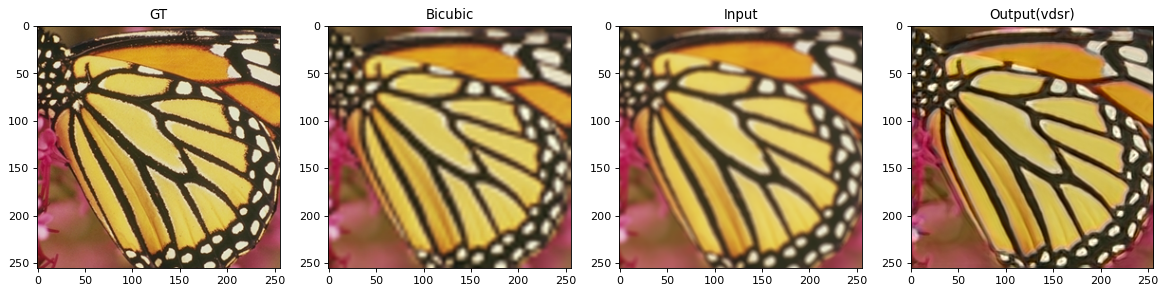

(<PIL.Image.Image image mode=RGB size=256x256 at 0x7FD6C7770BE0>,
 20.824648960041763,
 13.82117495265142)

In [52]:
display_PSNR(im_gt, im_b, im_b2, model)

# convert sample videos

In [53]:
folder = "/media/SSD/superres/Results/Superresolution train vdsr with perception loss multifuz/"

infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secperfuzmodel1-16.mp4"
superres_mp4(infile, outfile, model, factor=1.6,display=False,bitrate= "4000k")

  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss multifuz/muffins30secperfuzmodel1-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k


100%|██████████| 900/900 [00:28<00:00, 31.45it/s]


True

In [54]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secperfuzmodel1-10.mp4"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k")

  1%|          | 10/900 [00:00<00:09, 94.27it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss multifuz/muffins30secperfuzmodel1-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|██████████| 900/900 [00:08<00:00, 106.75it/s]


True

In [55]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secperfuzmodel1-20.mp4"
superres_mp4(infile, outfile, model, factor=2.0,display=False,bitrate= "4000k")

  0%|          | 2/900 [00:00<00:45, 19.69it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss multifuz/muffins30secperfuzmodel1-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k


100%|██████████| 900/900 [00:39<00:00, 23.01it/s]


True

In [56]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secperfuzmodel1-30.mp4"
superres_mp4(infile, outfile, model, factor=3.0,display=False,bitrate= "4000k")


  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss multifuz/muffins30secperfuzmodel1-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


100%|██████████| 900/900 [01:14<00:00, 12.10it/s]


True

In [57]:
dualfile= folder + "muffins30secperfuzmodel1-30dual.mp4"

In [58]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [59]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [60]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = folder + "super8perfuzmodel1.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/super8_best_from_mp2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss multifuz/super8perfuzmodel1.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 7195/7195 [04:36<00:00, 26.05it/s]


True

In [61]:

dualfile= folder + "super8perfuzmodel1dual.mp4"

In [62]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [63]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train vdsr with perception loss/super8percepmodel3.mp4"
outfile = folder + "super8perfuzmodel1.mp4"
dualfile= folder + "super8perfuzmodel1-tolast-dual.mp4"

In [64]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [65]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = folder + "super8longperfuzmodel1.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

  0%|          | 2/121409 [00:00<1:52:30, 17.99it/s]

Original File: /media/SSD/superres/super8/Old 8mm Reels_1.mp4
frames= 121409 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss multifuz/super8longperfuzmodel1.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 121409/121409 [1:16:25<00:00, 26.48it/s]


True

In [66]:
dualfile= folder + "super8longperfuzmodel1dual.mp4"

In [67]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [ ]:
def dual_superres_mp4(infile, outfile, dualfile, model, factor=1.0,errorfile = error_file):
    
    superres_mp4(infile, outfile, model, factor=factor,display=False,bitrate="4000k",errorfile = error_file)
    
    # original scale , for film x1, removed un needed scaling
    !ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = folder + "super8percepmodel2.mp4"
outfile = folder + "super8percepmodel2x2.mp4"
dualfile= folder + "super8percepmodel2x2x1dual.mp4"
error_file = "/media/SSD/superres/error.txt"

dual_superres_mp4(infile, outfile, dualfile, model, factor=1.0,errorfile = error_file)

infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
dualfile= folder + "super8percepmodel2x2origdual.mp4"

!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}